<a href="https://colab.research.google.com/github/whoami-Lory271/NN-project-memorizing-transformers/blob/main/NN_project_Antonelli_DeSantis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations and imports

In [1]:
!pip install pytorch_transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 29.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 9.9 MB/s eta 0:00:00


In [2]:
from pytorch_transformers import BertTokenizer
from pytorch_transformers import BertModel

In [3]:
!pip install torchdata --quiet
!pip install torchmetrics --quiet
!pip install torchtext --quiet
!pip install -U spacy --quiet
!python -m spacy download en_core_web_sm --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 4.0 MB/s eta 0:00:00


In [4]:
import torch
from torch import nn as nn
import numpy as np
from torch.nn import functional as F
from math import sqrt
import matplotlib.pyplot as plt
from torch.autograd import Variable
from pathlib import Path
from filelock import FileLock
import random
import tqdm
import gzip
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pickle as pkl
import torchtext
import torch
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
import spacy
from typing import Iterable, List
from torchtext.datasets import WikiText2
from torchmetrics.text.perplexity import Perplexity
from torchtext.vocab import build_vocab_from_iterator

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Dataset

In [6]:
# constants

NUM_BATCHES = int(1e5)
BATCH_SIZE = 16
SEQ_LEN = 512
HEADS = 8
DIM_HEAD = SEQ_LEN // HEADS

LEARNING_RATE = 1e-3 #2e-4 prima era così
MAX_GRAD_CLIP_NORM = 0.5

EVAL_EVERY = 20
GENERATE_EVERY  = 500
GENERATE_LENGTH = 512
CHECKPOINT = 10



In [7]:
train_iter, test_iter = WikiText2(split = ('train', 'test'))

In [ ]:
"""
from itertools import chain
data_iter = chain(train_iter, test_iter)
"""

In [ ]:
"""
token_transform = get_tokenizer('spacy', language = 'en_core_web_sm')

def yield_tokens(data) -> List[str]:
    for line in data:
        yield token_transform(line)

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

vocabulary_ = build_vocab_from_iterator(yield_tokens(data_iter), min_freq = 1, specials = special_symbols, special_first = True)
vocabulary_.set_default_index(UNK_IDX)
vocabulary_.__len__()
"""

In [ ]:
"""
def preprocessing_(dataset):
  new_ds = torch.tensor([], dtype = torch.int32)
  for line in dataset:
    tokenized_line = torch.tensor([vocabulary_[token] for token in token_transform(line)])
    new_ds = torch.cat((new_ds, tokenized_line))
  return new_ds
"""

In [ ]:
"""
train_ds = preprocessing_(train_iter)
test_ds = preprocessing_(test_iter)
"""

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 261967.05B/s]


In [9]:
def preprocessing(dataset):
  new_ds = []
  for line in dataset:
    tokenized_line = tokenizer.tokenize(line)
    new_ds.append(tokenized_line)
  return new_ds

In [10]:
train_ds = preprocessing(train_iter)
test_ds = preprocessing(test_iter)

In [11]:
def convert_tokens_to_idxs(dataset):
  new_ds = torch.tensor([], dtype = torch.int32)
  for line in dataset:
    tokenized_line = torch.tensor(tokenizer.convert_tokens_to_ids(line))    
    new_ds = torch.cat((new_ds, tokenized_line))
  return new_ds

In [ ]:
train_ds = convert_tokens_to_idxs(train_ds)
test_ds = convert_tokens_to_idxs(test_ds)

In [13]:
train_ds.shape

torch.Size([2405592])

In [14]:
vocabulary = 30522

In [15]:
train_loader = DataLoader(train_ds, batch_size = 10000, shuffle = False, drop_last = True)
print(len(train_loader))
train_ds = torch.zeros((len(train_loader), 10000), dtype = torch.int32)
for i, document in enumerate(train_loader):
  train_ds[i] = document

240


In [16]:
test_loader = DataLoader(test_ds, batch_size = 10000, shuffle = False, drop_last = True)

test_ds = torch.zeros((len(test_loader), 10000), dtype = torch.int32)
for i, document in enumerate(test_loader):
  test_ds[i] = document

In [17]:
train_ds.shape

torch.Size([240, 10000])

In [18]:
test_ds.shape

torch.Size([30, 10000])

# KNN Memory

In [19]:
!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 7.5 MB/s eta 0:00:00


In [20]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.4 MB/s eta 0:00:00


In [21]:
#import per la knn memory
import os
import math
import torch
import faiss
import numpy as np
from pathlib import Path
from functools import wraps

from contextlib import ExitStack, contextmanager

from einops import rearrange, pack, unpack

# multiprocessing

from joblib import Parallel, delayed, cpu_count

In [22]:
FAISS_INDEX_GPU_ID = int(os.getenv('FAISS_INDEX_GPU_ID', 0))

DEFAULT_KNN_MEMORY_MEMMAP_DIRECTORY = './.tmp/knn.memories'

# helper functions

def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def cast_list(val):
    return val if isinstance(val, list) else [val]

def all_el_unique(arr):
    return len(set(arr)) == len(arr)

@contextmanager
def multi_context(*cms):
    with ExitStack() as stack:
        yield [stack.enter_context(cls) for cls in cms]

def count_intersect(x, y):
    # returns an array that shows how many times an element in x is contained in tensor y
    return np.sum(rearrange(x, 'i -> i 1') == rearrange(y, 'j -> 1 j'), axis = -1)

def check_shape(tensor, pattern, **kwargs):
    return rearrange(tensor, f"{pattern} -> {pattern}", **kwargs)

# a wrapper around faiss IndexIVFFlat
# taking care of expiring old keys automagically

class KNN():
    def __init__(
        self,
        dim,
        max_num_entries,
        cap_num_entries = False,
        M = 15,
        keep_stats = False
    ):
        index = faiss.IndexHNSWFlat(dim, M, faiss.METRIC_INNER_PRODUCT)
        self.index = index
        self.max_num_entries = max_num_entries
        self.cap_num_entries = cap_num_entries
        self.is_trained = False
        self.keep_stats = keep_stats

        self.reset()

    def __del__(self):
        if hasattr(self, 'index'):
            del self.index

    def reset(self):
        self.ids = np.empty((0,), dtype = np.int32)

        if self.keep_stats:
            self.hits = np.empty((0,), dtype = np.int32)
            self.age_num_iterations = np.empty((0,), dtype = np.int32)
            self.ages_since_last_hit = np.empty((0,), dtype = np.int32)

        self.index.reset()
        self.is_trained = False

    def train(self, x):
        self.index.train(x)
        self.is_trained = True

    def add(self, x, ids):
        if not self.is_trained:
            self.train(x)

        self.ids = np.concatenate((ids, self.ids))

        if self.keep_stats:
            self.hits = np.concatenate((np.zeros_like(ids), self.hits))
            self.age_num_iterations = np.concatenate((np.zeros_like(ids), self.age_num_iterations))
            self.ages_since_last_hit = np.concatenate((np.zeros_like(ids), self.ages_since_last_hit))

        if self.cap_num_entries and len(self.ids) > self.max_num_entries:
            self.reset()

        return self.index.add(x)

    def search(
        self,
        x,
        topk,
        nprobe = 8,
        return_distances = False,
        increment_hits = False,
        increment_age = True
    ):
        if not self.is_trained:
            return np.full((x.shape[0], topk), -1)

        distances, indices = self.index.search(x, k = topk)

        if increment_hits and self.keep_stats:
            hits = count_intersect(self.ids, rearrange(indices, '... -> (...)'))
            self.hits += hits

            self.ages_since_last_hit += 1
            self.ages_since_last_hit *= (hits == 0)

        if increment_age and self.keep_stats:
            self.age_num_iterations += 1

        if return_distances:
            return indices, distances

        return indices

# KNN memory layer, where one can store key / value memories
# can automatically take care of a collection of faiss indices (across batch dimension)

class KNNMemory():
    def __init__(
        self,
        dim,
        max_memories = 16000,
        num_indices = 1,
        memmap_filename = './knn.memory.memmap',
        multiprocessing = True
    ):
        self.dim = dim
        self.num_indices = num_indices
        self.scoped_indices = list(range(num_indices))

        self.max_memories = max_memories
        self.shape = (num_indices, max_memories, 2, dim)
        self.db_offsets = np.zeros(num_indices, dtype = np.int32)

        self.db = np.memmap(memmap_filename, mode = 'w+', dtype = np.float32, shape = self.shape)
        self.knns = [KNN(dim = dim, max_num_entries = max_memories, cap_num_entries = True) for _ in range(num_indices)]
    
        self.n_jobs = cpu_count() if multiprocessing else 1

    def set_scoped_indices(self, indices):
        indices = list(indices)
        assert all_el_unique(indices), f'all scoped batch indices must be unique, received: {indices}'
        assert all([0 <= i < self.num_indices for i in indices]), f'each batch index must be between 0 and less than {self.num_indices}: received {indices}'
        self.scoped_indices = indices

    @contextmanager
    def at_batch_indices(self, indices):
        prev_indices = self.scoped_indices
        self.set_scoped_indices(indices)
        yield self
        self.set_scoped_indices(prev_indices)

    def clear(self, batch_indices = None):
        if not exists(batch_indices):
            batch_indices = list(range(self.num_indices))

        batch_indices = cast_list(batch_indices)

        for index in batch_indices:
            knn = self.knns[index]
            knn.reset()

        self.db_offsets[batch_indices] = 0

    def add(self, memories):
        check_shape(memories, 'b n kv d', d = self.dim, kv = 2, b = len(self.scoped_indices))

        memories = memories.detach().cpu().numpy()
        memories = memories[:, -self.max_memories:]
        num_memories = memories.shape[1]

        knn_insert_ids = np.arange(num_memories)

        keys = np.ascontiguousarray(memories[..., 0, :])
        knns = [self.knns[i] for i in self.scoped_indices]
        db_offsets = [self.db_offsets[i] for i in self.scoped_indices]

        # use joblib to insert new key / value memories into faiss index

        @delayed
        def knn_add(knn, key, db_offset):
            knn.add(key, ids = knn_insert_ids + db_offset)
            return knn

        updated_knns = Parallel(n_jobs = self.n_jobs)(knn_add(*args) for args in zip(knns, keys, db_offsets))
        for knn_idx, scoped_idx in enumerate(self.scoped_indices):
            self.knns[scoped_idx] = updated_knns[knn_idx]

        # add the new memories to the memmap "database"

        add_indices = (rearrange(np.arange(num_memories), 'j -> 1 j') + rearrange(self.db_offsets[list(self.scoped_indices)], 'i -> i 1')) % self.max_memories
        self.db[rearrange(np.array(self.scoped_indices), 'i -> i 1'), add_indices] = memories
        self.db.flush()

        self.db_offsets += num_memories

    def search(
        self,
        queries,
        topk,
        nprobe = 8,
        increment_hits = True,
        increment_age = True
    ):
        check_shape(queries, 'b ... d', d = self.dim, b = len(self.scoped_indices))
        queries, ps = pack([queries], 'b * d')

        device = queries.device
        queries = queries.detach().cpu().numpy()

        all_masks = []
        all_key_values = []

        knns = [self.knns[i] for i in self.scoped_indices]

        # parallelize faiss search

        @delayed
        def knn_search(knn, query):
            return knn.search(query, topk, nprobe, increment_hits = increment_hits, increment_age = increment_age)

        fetched_indices = Parallel(n_jobs = self.n_jobs)(knn_search(*args) for args in zip(knns, queries))

        # get all the memory key / values from memmap 'database'
        # todo - remove for loop below

        for batch_index, indices in zip(self.scoped_indices, fetched_indices):
            mask = indices !=  -1
            db_indices = np.where(mask, indices, 0)

            all_masks.append(torch.from_numpy(mask))

            key_values = self.db[batch_index, db_indices % self.max_memories]
            all_key_values.append(torch.from_numpy(key_values))

        all_masks = torch.stack(all_masks)
        all_key_values = torch.stack(all_key_values)
        all_key_values = all_key_values.masked_fill(~rearrange(all_masks, '... -> ... 1 1'), 0.)

        all_key_values, = unpack(all_key_values, ps, 'b * n kv d')
        all_masks, = unpack(all_masks, ps, 'b * n')

        return all_key_values.to(device), all_masks.to(device)

    def __del__(self):
        if hasattr(self, 'knns'):
            for knn in self.knns:
                del knn
        del self.db

# extends list with some extra methods for collections of KNN memories

class KNNMemoryList(list):
    def cleanup(self):
        for memory in self:
            del memory

    @classmethod
    def create_memories(
        self,
        *,
        batch_size,
        num_memory_layers,
        memories_directory = DEFAULT_KNN_MEMORY_MEMMAP_DIRECTORY
    ):
        memories_path = Path(memories_directory)
        memories_path.mkdir(exist_ok = True, parents = True)

        def inner(*args, **kwargs):
            return self([KNNMemory(*args, num_indices = batch_size, memmap_filename = str(memories_path / f'knn.memory.layer.{ind + 1}.memmap'), **kwargs) for ind in range(num_memory_layers)])
        return inner

    @contextmanager
    def at_batch_indices(
        self,
        indices
    ):
        knn_batch_indices_contexts = [memory.at_batch_indices(indices) for memory in self]
        with multi_context(*knn_batch_indices_contexts):
            yield

    def clear_memory(
        self,
        batch_indices = None,
        memory_indices = None
    ):
        memory_indices = default(memory_indices, tuple(range(len(self))))

        for memory_index in memory_indices:
            memory = self[memory_index]
            memory.clear(batch_indices)

# Memorizing transformers

In [23]:
def attention(query, key, value, sqrt_q, device, mask = None):
    t = torch.matmul(query, key.transpose(-2, -1))/sqrt_q
    if mask is not None:
      t = t.masked_fill_(mask == 0, -1e-9)
    return torch.matmul(F.softmax(t, dim = -1), value)

def KNNattention(query, key, value, sqrt_q, mask):
    t = torch.einsum('b h i q, b h i j q -> b h i j', query, key)/sqrt_q
    return torch.einsum('b h i j, b h i j q -> b h i q', F.softmax(t.masked_fill_(mask, -1e-9), dim = -1), value)

In [24]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d, h, batch_size):
    super(MultiHeadAttention, self).__init__()
    assert d % h == 0
    #assume q = v 
    self.q = d // h #single head dimension
    self.sqrt_q = sqrt(self.q)
    self.h = h
    self.batch_size = batch_size
    self.W_q = nn.Linear(d, d, bias = False) #stack of h matrices of dimension (d, q), one for each head
    self.W_k = nn.Linear(d, d, bias = False)
    self.W_v = nn.Linear(d, d, bias = False)
    self.W_o = nn.Linear(d, d, bias = False)

  def forward(self, x, mask = None):
    query = self.W_q(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
    key = self.W_k(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
    value = self.W_v(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
    #new_memories = torch.stack((key, value), dim = -2).detach()
    attention_value = attention(query, key, value, self.sqrt_q, mask)
    return self.W_o(attention_value.transpose(1, 2).contiguous().view(self.batch_size, -1, self.h*self.q))

In [25]:
class KNNAttention(nn.Module):
   def __init__(self, d, h, batch_size, num_retrieved_memories):
      super(KNNAttention, self).__init__()
      assert d % h == 0
      #assume q = v 
      self.q = d // h
      self.sqrt_q = sqrt(self.q)
      self.h = h
      self.W_q = nn.Linear(d, d, bias = False)
      self.W_k = nn.Linear(d, d, bias = False)
      self.W_v = nn.Linear(d, d, bias = False)
      self.W_o = nn.Linear(d, d, bias = False)
      self.b_g = nn.Parameter(torch.randn((h,))) #one for each head
      self.num_retrieved_memories = num_retrieved_memories
      self.batch_size = batch_size

   def forward(self, x, mask, knn_memory):
      # calculate local attention 
      query = self.W_q(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
      key = self.W_k(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
      value = self.W_v(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
      local_attention = attention(query, key, value, self.sqrt_q, mask)

      # calculate knn attention over memory
      query = F.normalize(query, dim = -1)
      key = F.normalize(key, dim = -1)
      mem_kv, mem_mask = knn_memory.search(query, self.num_retrieved_memories)
      mem_key, mem_value = mem_kv.unbind(dim = -2)
      knn_attention = KNNattention(query, mem_key, mem_value, self.sqrt_q, ~mem_mask)

      # memory to be stored
      new_kv_memories = torch.stack((key, value), dim = -2).view(self.batch_size, -1, 2, self.q).detach()

      # add to knn memory
      if new_kv_memories.numel() > 0:
        knn_memory.add(new_kv_memories)

      # combining local and memory
      g = torch.sigmoid(self.b_g)
      final_attention = torch.einsum('b h n q, h -> b h n q', knn_attention, g) + \
                        torch.einsum('b h n q, h -> b h n q', local_attention, (1 - g))
      
      return self.W_o(final_attention.transpose(1, 2).contiguous().view(self.batch_size, -1, self.h*self.q))

In [26]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len=5000):
    super(PositionalEncoding, self).__init__()
    
    # Compute the positional encodings once in log space.
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) *
                          -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)
      
  def forward(self, x):
    return x + Variable(self.pe[:, :x.size(1)], requires_grad=False)

In [27]:
class TransformerBlock(nn.Module):
  def __init__(self, d, h, batch_size, hidden_size, dropout, is_mem = False, num_retrieved_memories = 32):
    super(TransformerBlock, self).__init__()
    self.d = d
    self.h = h
    self.batch_size = batch_size
    self.attention = MultiHeadAttention(d, h, batch_size) if not is_mem else KNNAttention(d, h, batch_size, num_retrieved_memories)
    self.norm1 = nn.LayerNorm(d)
    self.dropout1 = nn.Dropout(dropout)
    self.norm2 = nn.LayerNorm(d)
    self.dropout2 = nn.Dropout(dropout)
    self.ff = nn.Sequential(nn.Linear(d, hidden_size, bias = True), 
                            nn.ReLU(),
                            nn.Dropout(dropout),
                            nn.Linear(hidden_size, d, bias = True))
  def forward(self, x, mask, knn_memory = None):
    if knn_memory is None:
      x = self.attention(x, mask)
    else:
      x = self.attention(x, mask, knn_memory)
    x = self.dropout1(x + self.norm1(x))
    x = x + self.ff(x)
    x = self.dropout2(self.norm2(x))
    return x

In [28]:
class DecoderBlock(nn.Module): #block of the classic transformer decoder (not used)
  def __init__(self, d, h, batch_size, hidden_size, dropout):
    super(DecoderBlock, self).__init__()
    self.attention = MultiHeadAttention(d, h, batch_size)
    self.norm = nn.LayerNorm(d)
    self.dropout = nn.Dropout(dropout)
    self.transformer_block = TransformerBlock(d, h, batch_size, hidden_size, dropout)

  def forward(self, x, mask):
    x = self.attention(x, mask)
    x = self.dropout(self.norm(x))
    return self.transformer_block(x)

In [29]:
class MemorizingTransformer(nn.Module):
    def __init__(
          self,
          num_tokens,
          d,
          heads = 8,
          depth = 4,
          knn_attn_idx = 2,
          attn_dropout = 0.,
          hidden_size = 1000,
          dropout = 0.3,
          max_knn_memories = 1000,
          num_retrieved_memories = 32,
          batch_size = 16,
          use_bert = True
      ):
          # asserts
          self.d = d if not use_bert else 768
          assert self.d % heads == 0
          assert knn_attn_idx < depth

          super(MemorizingTransformer, self).__init__()
          #self.token_emb = nn.Embedding(num_tokens, self.d) #without BERT
          self.token_emb = BertModel.from_pretrained('bert-base-uncased')
          self.positional_enc = PositionalEncoding(self.d, max_len = 5000)
          self.dim_head = self.d // heads
          
          self.heads = heads
          self.knn_attn_idx = knn_attn_idx
          self.depth = depth
          self.attn_dropout = attn_dropout
          self.hidden_size = hidden_size
          self.dropout = dropout
          self.max_knn_memories = max_knn_memories
          self.num_retrieved_memories = num_retrieved_memories
          self.batch_size = batch_size

          self.layers = nn.ModuleList([])
          for idx in range(depth):
            self.layers.append(
                TransformerBlock(self.d, heads, batch_size, hidden_size, dropout, is_mem = idx == self.knn_attn_idx)
            )

          self.to_out = nn.Linear(self.d, num_tokens)
    
    def create_mask(self, x):
      batch_size, seq_len = x.shape
      mask = torch.tril(torch.ones((seq_len, seq_len))).expand(
          batch_size, 1, seq_len, seq_len)
      return mask    
          
    def forward(self, x, knn_memory):
      mask = self.create_mask(x)
      #x = self.token_emb(x) #without BERT
      x = self.token_emb(x)[0] #with BERT
      x = self.positional_enc(x)

      for idx in range(self.depth):
          x= self.layers[idx](x, mask, knn_memory = knn_memory if idx == self.knn_attn_idx else None)

      return self.to_out(x).transpose(1, 2)

# Training

In [31]:
# constants

BATCH_SIZE = 4
SEQ_LEN = 256
SEGMENTS = 5
HEADS = 8
DIM_HEAD = SEQ_LEN // HEADS 
DIM_HEAD_BERT = 768 // HEADS #now it's 96 with bert -> 768/8

LEARNING_RATE = 2e-4
MAX_GRAD_CLIP_NORM = 0.5

EVAL_EVERY = 1
CHECKPOINT = 1

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MemorizingTransformer(
    num_tokens = vocabulary,
    d = SEQ_LEN,
    heads = HEADS,
    batch_size = BATCH_SIZE,
    depth = 10,
    knn_attn_idx = 8,
    num_retrieved_memories = 32,
    use_bert = True #False if you want to try without BERT
).to(device)

memory = KNNMemory(
    dim = DIM_HEAD_BERT,       #substitute with DIM_HEAD if you want to try without BERT
    max_memories = 1000,       #maximum number of memories (old ones will be discarded after reaching maximum capacity)
    num_indices = BATCH_SIZE   #each batch keeps track of its own memories, expiring when it sees a new document
)

train_loader_ = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)
test_loader_ = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)

100%|██████████| 440473133/440473133 [00:36<00:00, 12016222.79B/s]


In [ ]:
def print_string(a):
  seq = ""
  for word in a:
    for letter in word:
      seq += chr(letter)
    seq += " "
  return seq

In [33]:
# optimizer

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
loss = nn.CrossEntropyLoss()
epochs = 5
# training

perplexity_list = []

for e in range(epochs):
  for i, data in enumerate(tqdm.tqdm(train_loader_, desc = 'training')):
    model.train()

    train_loss = 0.

    num_seq = 10000 // (SEQ_LEN + 1)
    data = data.long().to(device)
    for j in range(num_seq):
      mini_batch = data[:, j*(SEQ_LEN + 1):(j+1)*(SEQ_LEN + 1)]
      seq, labels = mini_batch[:, :-1], mini_batch[:, 1:]
      out = model(
        seq,
        knn_memory = memory
      )
      loss_item = loss(out, labels)
      print(f'training loss: {loss_item}', flush = True)
      loss_item.backward() 
      torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_CLIP_NORM)
      optimizer.step()
      optimizer.zero_grad()
  data = None
    

  if e % EVAL_EVERY == 0:
    model.eval()

    with torch.no_grad():
      metric = Perplexity().to(device)
      for i, data in enumerate(tqdm.tqdm(test_loader_, desc = 'evaluation')):
        num_seq = 10000 // (SEQ_LEN + 1)
        data = data.long().to(device)

        for j in range(num_seq):
          mini_batch = data[:, j*(SEQ_LEN + 1):(j+1)*(SEQ_LEN + 1)]
          seq, labels = mini_batch[:, :-1], mini_batch[:, 1:]
          out = model(
            seq,
            knn_memory = memory
          )
          test_loss = loss(out, labels)
          metric(out.transpose(1, 2), labels)
          print(f'test loss: {test_loss}', flush = True)

      perplexity = metric.compute()
      perplexity_list.append(perplexity)
      print(f'perplexity: {perplexity}', flush = True)

  data = None
  if e % CHECKPOINT == 0:
    torch.save({
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
    }, 'model_optimizer.pt')
  """
  #Lorenzo
  with open('/content/drive/MyDrive/Università/Magistrale/Secondo Anno/Neural Networks/project/perplexity_moreNN.npy', 'wb') as f:
    np.save(f, np.array(perplexity_list))
  """

plt.plot(perplexity_list, label = "Memorizing Transformer Perplexity Plot")
plt.legend()
plt.show()

training:   0%|          | 0/60 [00:00<?, ?it/s]

training loss: 10.613636016845703
training loss: 10.138771057128906
training loss: 9.531482696533203
training loss: 9.290334701538086
training loss: 9.037982940673828
training loss: 8.964811325073242
training loss: 8.834417343139648
training loss: 8.868087768554688
training loss: 8.449191093444824
training loss: 8.274097442626953
training loss: 8.287134170532227
training loss: 8.253252029418945
training loss: 8.065546989440918
training loss: 7.983259201049805
training loss: 7.921478748321533
training loss: 7.658079624176025
training loss: 7.6776123046875
training loss: 7.544704437255859
training loss: 7.428136825561523
training loss: 7.556718826293945
training loss: 7.667337894439697
training loss: 7.271917819976807
training loss: 7.241058826446533
training loss: 7.298427581787109
training loss: 7.0697197914123535
training loss: 7.1090803146362305
training loss: 7.217362403869629
training loss: 6.955743789672852
training loss: 6.869659900665283
training loss: 6.926031112670898
training

training:   2%|▏         | 1/60 [00:43<42:23, 43.12s/it]

training loss: 7.084143161773682
training loss: 7.394591331481934
training loss: 7.657687187194824
training loss: 7.305431842803955
training loss: 7.273122787475586
training loss: 7.156654357910156
training loss: 7.343154430389404
training loss: 6.991386413574219
training loss: 7.358992099761963
training loss: 7.178823471069336
training loss: 7.169069766998291
training loss: 6.862148761749268
training loss: 7.171343803405762
training loss: 7.3018083572387695
training loss: 7.156015872955322
training loss: 6.985560417175293
training loss: 7.023008823394775
training loss: 7.0046234130859375
training loss: 6.907008647918701
training loss: 7.088797569274902
training loss: 7.021082878112793
training loss: 7.007051467895508
training loss: 6.970407009124756
training loss: 7.39532995223999
training loss: 7.165580749511719
training loss: 7.112638473510742
training loss: 7.049008369445801
training loss: 7.1853437423706055
training loss: 6.966651916503906
training loss: 7.035217761993408
training

training:   3%|▎         | 2/60 [01:21<38:46, 40.11s/it]

training loss: 7.078865051269531
training loss: 7.060799598693848
training loss: 7.193464279174805
training loss: 7.1889238357543945
training loss: 7.151512145996094
training loss: 7.017027378082275
training loss: 7.268648147583008
training loss: 7.3830413818359375
training loss: 7.186588764190674
training loss: 6.901195526123047
training loss: 6.994412422180176
training loss: 7.237492561340332
training loss: 7.301083564758301
training loss: 7.216693878173828
training loss: 6.944808006286621
training loss: 6.840197563171387
training loss: 7.095056533813477
training loss: 7.078004837036133
training loss: 7.063430309295654
training loss: 6.90178108215332
training loss: 7.1105828285217285
training loss: 6.874146461486816
training loss: 7.080276012420654
training loss: 6.863290786743164
training loss: 6.918060302734375
training loss: 6.7738518714904785
training loss: 7.038888931274414
training loss: 6.742169380187988
training loss: 6.645608425140381
training loss: 6.800784111022949
trainin

training:   5%|▌         | 3/60 [01:59<37:10, 39.14s/it]

training loss: 6.825892448425293
training loss: 7.082074165344238
training loss: 7.292474746704102
training loss: 7.1592488288879395
training loss: 7.309303283691406
training loss: 7.078857421875
training loss: 7.298160552978516
training loss: 7.097609519958496
training loss: 6.8863115310668945
training loss: 6.977092742919922
training loss: 6.86734676361084
training loss: 6.951988220214844
training loss: 7.229460716247559
training loss: 6.816893577575684
training loss: 6.758791923522949
training loss: 6.830312252044678
training loss: 6.823642730712891
training loss: 7.093572616577148
training loss: 6.873366355895996
training loss: 6.90254020690918
training loss: 6.862163543701172
training loss: 6.987902641296387
training loss: 7.076012134552002
training loss: 6.570353031158447
training loss: 7.0134501457214355
training loss: 6.997167110443115
training loss: 7.096169471740723
training loss: 6.886145114898682
training loss: 6.836856842041016
training loss: 7.074459552764893
training los

training:   7%|▋         | 4/60 [02:37<36:06, 38.69s/it]

training loss: 7.272273540496826
training loss: 6.745721817016602
training loss: 6.89892578125
training loss: 7.012731552124023
training loss: 6.670243263244629
training loss: 6.968606948852539
training loss: 7.081724643707275
training loss: 6.848888397216797
training loss: 6.632232189178467
training loss: 7.32260799407959
training loss: 7.2416157722473145
training loss: 7.380533218383789
training loss: 7.190946102142334
training loss: 7.096787929534912
training loss: 7.04904842376709
training loss: 7.074018478393555
training loss: 7.16287899017334
training loss: 7.128839015960693
training loss: 7.237271308898926
training loss: 7.105903625488281
training loss: 7.353597640991211
training loss: 7.130156993865967
training loss: 7.231752395629883
training loss: 6.910612106323242
training loss: 6.913682460784912
training loss: 6.591948509216309
training loss: 6.972830772399902
training loss: 7.076026916503906
training loss: 7.274300575256348
training loss: 7.024515151977539
training loss: 7

training:   8%|▊         | 5/60 [03:14<35:08, 38.34s/it]

training loss: 6.933565139770508
training loss: 6.95356559753418
training loss: 7.490050315856934
training loss: 7.350604057312012
training loss: 7.142333030700684
training loss: 6.6896209716796875
training loss: 6.899460792541504
training loss: 6.928689956665039
training loss: 7.198765277862549
training loss: 7.024230003356934
training loss: 7.024910926818848
training loss: 7.0703558921813965
training loss: 6.751494884490967
training loss: 6.930469036102295
training loss: 6.959268569946289
training loss: 6.890024185180664
training loss: 6.736353874206543
training loss: 6.629390716552734
training loss: 6.485001564025879
training loss: 6.58930778503418
training loss: 6.82376766204834
training loss: 6.905578136444092
training loss: 6.852627754211426
training loss: 6.908886909484863
training loss: 6.94565486907959
training loss: 6.753915786743164
training loss: 6.804279327392578
training loss: 6.7591118812561035
training loss: 6.7900919914245605
training loss: 6.955374240875244
training l

training:  10%|█         | 6/60 [03:52<34:23, 38.21s/it]

training loss: 7.276799201965332
training loss: 7.325370788574219
training loss: 7.2664875984191895
training loss: 7.210224628448486
training loss: 6.998112201690674
training loss: 7.302657604217529
training loss: 7.2073283195495605
training loss: 7.117082118988037
training loss: 7.020355224609375
training loss: 6.927463531494141
training loss: 7.00570011138916
training loss: 6.733159065246582
training loss: 6.8763251304626465
training loss: 7.209510803222656
training loss: 7.254376411437988
training loss: 7.037599563598633
training loss: 6.713640213012695
training loss: 7.083306789398193
training loss: 7.19444465637207
training loss: 7.101696968078613
training loss: 6.839553356170654
training loss: 6.886813640594482
training loss: 7.18438196182251
training loss: 6.962347984313965
training loss: 6.862087726593018
training loss: 6.954755783081055
training loss: 6.992542743682861
training loss: 6.7206807136535645
training loss: 7.1658172607421875
training loss: 6.856204032897949
training

training:  12%|█▏        | 7/60 [04:31<33:58, 38.47s/it]

training loss: 7.122234344482422
training loss: 7.066431999206543
training loss: 7.157933235168457
training loss: 7.136859893798828
training loss: 7.191762447357178
training loss: 7.2710113525390625
training loss: 7.101606845855713
training loss: 6.848149299621582
training loss: 6.92459774017334
training loss: 6.726385116577148
training loss: 6.677337646484375
training loss: 6.701813697814941
training loss: 6.9286370277404785
training loss: 6.641932487487793
training loss: 6.70519495010376
training loss: 6.675601005554199
training loss: 6.6327667236328125
training loss: 6.768328666687012
training loss: 6.411677360534668
training loss: 6.753479480743408
training loss: 6.725071907043457
training loss: 6.826328754425049
training loss: 6.859999179840088
training loss: 6.804537296295166
training loss: 6.64241886138916
training loss: 7.016724586486816
training loss: 6.624906539916992
training loss: 7.011223793029785
training loss: 6.836832046508789
training loss: 6.929080963134766
training l

training:  13%|█▎        | 8/60 [05:09<33:11, 38.29s/it]

training loss: 7.230232238769531
training loss: 7.401898384094238
training loss: 7.140575408935547
training loss: 7.138494491577148
training loss: 6.938142776489258
training loss: 6.995104789733887
training loss: 6.7921576499938965
training loss: 7.038303375244141
training loss: 7.236082077026367
training loss: 7.155353546142578
training loss: 7.201041221618652
training loss: 7.012529373168945
training loss: 6.8622894287109375
training loss: 7.025600910186768
training loss: 7.028053283691406
training loss: 7.2305731773376465
training loss: 6.869088649749756
training loss: 6.697502136230469
training loss: 6.960309982299805
training loss: 6.909814834594727
training loss: 7.0569167137146
training loss: 6.75325870513916
training loss: 6.869870185852051
training loss: 6.91953182220459
training loss: 7.024238586425781
training loss: 6.9305009841918945
training loss: 6.83516788482666
training loss: 7.134149551391602
training loss: 7.104081630706787
training loss: 6.922067642211914
training lo

training:  15%|█▌        | 9/60 [05:47<32:25, 38.14s/it]

training loss: 7.1218695640563965
training loss: 7.287310600280762
training loss: 6.878499507904053
training loss: 6.700962543487549
training loss: 6.767308235168457
training loss: 7.087644577026367
training loss: 6.962769508361816
training loss: 6.950863838195801
training loss: 6.883501052856445
training loss: 6.631229400634766
training loss: 6.893355369567871
training loss: 6.880991458892822
training loss: 6.520962238311768
training loss: 6.412832260131836
training loss: 6.1856465339660645
training loss: 6.400476455688477
training loss: 6.707627296447754
training loss: 6.652065753936768
training loss: 6.940911293029785
training loss: 7.120311260223389
training loss: 7.014995574951172
training loss: 7.059335231781006
training loss: 7.264331340789795
training loss: 6.934560775756836
training loss: 7.024728298187256
training loss: 6.932506561279297
training loss: 7.235857009887695
training loss: 7.225761890411377
training loss: 7.209053039550781
training loss: 6.917325019836426
training

training:  17%|█▋        | 10/60 [06:25<31:41, 38.03s/it]

training loss: 7.091666221618652
training loss: 7.047573566436768
training loss: 7.173423767089844
training loss: 7.077314376831055
training loss: 7.258548736572266
training loss: 6.962238311767578
training loss: 6.981310844421387
training loss: 7.213936805725098
training loss: 6.825651168823242
training loss: 7.214226722717285
training loss: 6.944949150085449
training loss: 7.251262664794922
training loss: 7.005843162536621
training loss: 6.876096725463867
training loss: 7.114564895629883
training loss: 6.91652774810791
training loss: 6.842278480529785
training loss: 6.742606163024902
training loss: 6.757969856262207
training loss: 6.735848426818848
training loss: 6.88299560546875
training loss: 6.998140811920166
training loss: 7.003684997558594
training loss: 7.028613090515137
training loss: 7.051494598388672
training loss: 7.02492618560791
training loss: 6.903160572052002
training loss: 6.947887897491455
training loss: 6.965079307556152
training loss: 6.9401397705078125
training los

training:  18%|█▊        | 11/60 [07:03<31:07, 38.11s/it]

training loss: 6.955634593963623
training loss: 7.1803388595581055
training loss: 7.072729110717773
training loss: 6.7278900146484375
training loss: 7.017607688903809
training loss: 7.029693126678467
training loss: 6.882510185241699
training loss: 6.911130428314209
training loss: 6.834501266479492
training loss: 6.91484260559082
training loss: 7.068324089050293
training loss: 6.8723859786987305
training loss: 6.872129440307617
training loss: 6.753278732299805
training loss: 6.837377548217773
training loss: 6.813639163970947
training loss: 6.654955863952637
training loss: 6.812917709350586
training loss: 6.561501502990723
training loss: 6.757495880126953
training loss: 6.883272171020508
training loss: 6.950472831726074
training loss: 6.933416366577148
training loss: 6.996332168579102
training loss: 7.05186653137207
training loss: 6.891727447509766
training loss: 6.849225044250488
training loss: 6.860954284667969
training loss: 7.03660774230957
training loss: 6.77847957611084
training lo

training:  20%|██        | 12/60 [07:43<30:52, 38.59s/it]

training loss: 7.381464004516602
training loss: 6.8945512771606445
training loss: 6.690036773681641
training loss: 7.007118225097656
training loss: 7.031467437744141
training loss: 6.4006876945495605
training loss: 6.732710838317871
training loss: 6.964254379272461
training loss: 7.1317620277404785
training loss: 6.971085548400879
training loss: 6.948525428771973
training loss: 7.107857704162598
training loss: 6.965453147888184
training loss: 6.911659240722656
training loss: 6.920713424682617
training loss: 6.905270576477051
training loss: 6.550041198730469
training loss: 6.871432304382324
training loss: 6.811529159545898
training loss: 6.8191351890563965
training loss: 7.012104034423828
training loss: 7.035736560821533
training loss: 6.879207611083984
training loss: 6.783276557922363
training loss: 7.057758331298828
training loss: 6.896347999572754
training loss: 6.741536617279053
training loss: 6.757274627685547
training loss: 6.641307830810547
training loss: 6.933543682098389
traini

training:  22%|██▏       | 13/60 [08:21<30:03, 38.38s/it]

training loss: 7.13232946395874
training loss: 7.105768203735352
training loss: 7.083372592926025
training loss: 6.994720458984375
training loss: 6.975953578948975
training loss: 7.074357032775879
training loss: 6.947361946105957
training loss: 6.68681526184082
training loss: 6.623019218444824
training loss: 6.9031572341918945
training loss: 6.839829444885254
training loss: 6.917774200439453
training loss: 6.843218803405762
training loss: 7.1470441818237305
training loss: 6.910722255706787
training loss: 6.870024681091309
training loss: 6.83977746963501
training loss: 7.072990417480469
training loss: 7.13715934753418
training loss: 6.692280292510986
training loss: 6.843554496765137
training loss: 6.922203063964844
training loss: 6.964837551116943
training loss: 6.9279608726501465
training loss: 6.788494110107422
training loss: 6.7820940017700195
training loss: 6.992270469665527
training loss: 6.723076820373535
training loss: 6.865383625030518
training loss: 6.736015319824219
training l

training:  23%|██▎       | 14/60 [08:59<29:18, 38.24s/it]

training loss: 7.244021892547607
training loss: 7.189414024353027
training loss: 7.168315410614014
training loss: 7.274123191833496
training loss: 7.257654666900635
training loss: 7.05896520614624
training loss: 7.251628875732422
training loss: 7.004082679748535
training loss: 7.015024185180664
training loss: 7.156121730804443
training loss: 7.050822734832764
training loss: 6.989840030670166
training loss: 6.946094512939453
training loss: 6.726750373840332
training loss: 6.73920202255249
training loss: 6.752025604248047
training loss: 6.8838911056518555
training loss: 7.047333717346191
training loss: 7.111050605773926
training loss: 6.919071197509766
training loss: 7.135094165802002
training loss: 7.007986068725586
training loss: 6.885394096374512
training loss: 6.9074177742004395
training loss: 6.933279991149902
training loss: 6.938861846923828
training loss: 6.890046119689941
training loss: 7.019357204437256
training loss: 6.989985466003418
training loss: 6.676540374755859
training l

training:  25%|██▌       | 15/60 [09:37<28:39, 38.21s/it]

training loss: 6.993119716644287
training loss: 6.784221649169922
training loss: 7.126415729522705
training loss: 7.195370674133301
training loss: 7.15617561340332
training loss: 7.264147758483887
training loss: 7.056883335113525
training loss: 7.247528553009033
training loss: 7.2397332191467285
training loss: 7.222484111785889
training loss: 7.2690839767456055
training loss: 7.034571647644043
training loss: 7.0977630615234375
training loss: 6.7696380615234375
training loss: 7.01775598526001
training loss: 6.995601654052734
training loss: 6.75364875793457
training loss: 6.914153099060059
training loss: 7.088861465454102
training loss: 6.797702789306641
training loss: 6.912065505981445
training loss: 6.912803649902344
training loss: 7.174559116363525
training loss: 7.117282390594482
training loss: 7.095465660095215
training loss: 6.541790008544922
training loss: 6.842745780944824
training loss: 7.1712493896484375
training loss: 7.127444267272949
training loss: 6.603798866271973
training

training:  27%|██▋       | 16/60 [10:15<28:00, 38.20s/it]

training loss: 6.995940208435059
training loss: 7.082773208618164
training loss: 7.305164337158203
training loss: 7.161197662353516
training loss: 7.269604682922363
training loss: 7.057260990142822
training loss: 7.041745185852051
training loss: 6.9116129875183105
training loss: 7.012732028961182
training loss: 6.924648761749268
training loss: 6.9260783195495605
training loss: 7.066951274871826
training loss: 6.945458889007568
training loss: 7.137029647827148
training loss: 6.992270469665527
training loss: 7.037405014038086
training loss: 7.032413005828857
training loss: 7.048299312591553
training loss: 7.010881423950195
training loss: 6.879522323608398
training loss: 6.845816612243652
training loss: 7.069371223449707
training loss: 7.0687761306762695
training loss: 7.199522018432617
training loss: 7.182771682739258
training loss: 7.122307777404785
training loss: 6.9342498779296875
training loss: 6.838376522064209
training loss: 6.903219223022461
training loss: 6.763131141662598
traini

training:  28%|██▊       | 17/60 [10:58<28:21, 39.58s/it]

training loss: 7.12001895904541
training loss: 7.266022682189941
training loss: 7.047516822814941
training loss: 7.0406389236450195
training loss: 6.897774696350098
training loss: 6.815616607666016
training loss: 7.008540153503418
training loss: 6.860357284545898
training loss: 6.795193672180176
training loss: 6.812383651733398
training loss: 6.7417778968811035
training loss: 6.879680633544922
training loss: 6.854953765869141
training loss: 6.882869720458984
training loss: 7.134745121002197
training loss: 7.05328893661499
training loss: 7.036424160003662
training loss: 6.804134368896484
training loss: 6.966885566711426
training loss: 7.036844253540039
training loss: 6.986448764801025
training loss: 6.684329032897949
training loss: 6.9523396492004395
training loss: 7.10272216796875
training loss: 6.87905216217041
training loss: 6.9057159423828125
training loss: 7.012053489685059
training loss: 6.9983015060424805
training loss: 6.762081623077393
training loss: 6.548131942749023
training 

training:  30%|███       | 18/60 [11:41<28:27, 40.65s/it]

training loss: 7.261334419250488
training loss: 7.118507385253906
training loss: 7.239687919616699
training loss: 6.87838888168335
training loss: 7.214639186859131
training loss: 7.240421295166016
training loss: 7.151341438293457
training loss: 7.2515363693237305
training loss: 6.784528732299805
training loss: 7.0007476806640625
training loss: 7.153294563293457
training loss: 6.932985782623291
training loss: 7.027744293212891
training loss: 6.96490478515625
training loss: 7.021378517150879
training loss: 6.996851444244385
training loss: 7.000884056091309
training loss: 6.751984596252441
training loss: 7.058529853820801
training loss: 7.111053943634033
training loss: 7.272870063781738
training loss: 7.077937126159668
training loss: 7.01859188079834
training loss: 6.947611331939697
training loss: 6.953092098236084
training loss: 6.842789173126221
training loss: 6.86737585067749
training loss: 6.959402084350586
training loss: 6.901716232299805
training loss: 6.663630485534668
training los

training:  32%|███▏      | 19/60 [12:19<27:14, 39.86s/it]

training loss: 6.853694915771484
training loss: 7.049633979797363
training loss: 7.307528972625732
training loss: 7.142012596130371
training loss: 7.105103969573975
training loss: 7.113703727722168
training loss: 7.003873825073242
training loss: 6.8922576904296875
training loss: 6.9274468421936035
training loss: 7.039277076721191
training loss: 7.133861541748047
training loss: 7.052985668182373
training loss: 7.100751876831055
training loss: 7.447279930114746
training loss: 7.212275505065918
training loss: 7.225264072418213
training loss: 6.845485210418701
training loss: 6.972207069396973
training loss: 6.962765693664551
training loss: 6.58221960067749
training loss: 6.867555618286133
training loss: 6.8560638427734375
training loss: 7.110095977783203
training loss: 6.9389801025390625
training loss: 7.145419120788574
training loss: 6.809142112731934
training loss: 6.9658613204956055
training loss: 6.652544021606445
training loss: 6.691473007202148
training loss: 6.996174335479736
traini

training:  33%|███▎      | 20/60 [12:57<26:19, 39.49s/it]

training loss: 6.920068264007568
training loss: 7.2850751876831055
training loss: 7.002172470092773
training loss: 7.062807083129883
training loss: 6.8733649253845215
training loss: 6.888821601867676
training loss: 6.999100685119629
training loss: 7.06151819229126
training loss: 6.949859142303467
training loss: 7.087446212768555
training loss: 7.071084976196289
training loss: 7.103525161743164
training loss: 7.05394172668457
training loss: 6.955443859100342
training loss: 6.997477054595947
training loss: 6.822092056274414
training loss: 6.8947882652282715
training loss: 7.095067977905273
training loss: 7.008118152618408
training loss: 6.844754219055176
training loss: 6.74705171585083
training loss: 6.781914234161377
training loss: 7.0517988204956055
training loss: 6.751018524169922
training loss: 6.884237289428711
training loss: 6.793133735656738
training loss: 6.919988632202148
training loss: 6.7969970703125
training loss: 6.903903484344482
training loss: 7.0257768630981445
training l

training:  35%|███▌      | 21/60 [13:39<26:03, 40.08s/it]

training loss: 7.129133224487305
training loss: 7.05056095123291
training loss: 6.834190368652344
training loss: 6.841165542602539
training loss: 6.942766189575195
training loss: 6.994068622589111
training loss: 6.782136917114258
training loss: 6.922613620758057
training loss: 6.55466365814209
training loss: 6.720989227294922
training loss: 6.8983869552612305
training loss: 6.895124435424805
training loss: 6.602025032043457
training loss: 7.140628337860107
training loss: 6.949765205383301
training loss: 6.891237735748291
training loss: 6.773731708526611
training loss: 6.862243175506592
training loss: 7.251828670501709
training loss: 7.062057971954346
training loss: 7.0432233810424805
training loss: 7.202770233154297
training loss: 7.15321159362793
training loss: 7.026019096374512
training loss: 6.908143997192383
training loss: 6.924454689025879
training loss: 6.50697135925293
training loss: 6.93831205368042
training loss: 6.678504467010498
training loss: 6.70719051361084
training loss:

training:  37%|███▋      | 22/60 [14:18<25:16, 39.91s/it]

training loss: 7.210700035095215
training loss: 7.280634880065918
training loss: 7.1201863288879395
training loss: 6.921036243438721
training loss: 6.899633407592773
training loss: 6.9862518310546875
training loss: 6.829773902893066
training loss: 6.903101921081543
training loss: 6.9680914878845215
training loss: 6.660061836242676
training loss: 6.790430545806885
training loss: 6.796070575714111
training loss: 6.892922878265381
training loss: 6.853414535522461
training loss: 7.020436763763428
training loss: 6.913593769073486
training loss: 6.700383186340332
training loss: 6.890918731689453
training loss: 7.216863632202148
training loss: 7.251250743865967
training loss: 7.029544830322266
training loss: 7.122547149658203
training loss: 6.744854927062988
training loss: 6.936036586761475
training loss: 6.73862886428833
training loss: 6.958298683166504
training loss: 6.93310546875
training loss: 7.10394287109375
training loss: 6.998194694519043
training loss: 6.963395595550537
training loss

training:  38%|███▊      | 23/60 [15:00<24:51, 40.31s/it]

training loss: 6.967005252838135
training loss: 6.981806755065918
training loss: 7.071987152099609
training loss: 7.023414611816406
training loss: 7.019271373748779
training loss: 7.0901336669921875
training loss: 7.2707061767578125
training loss: 6.9417572021484375
training loss: 7.117517471313477
training loss: 7.102762699127197
training loss: 7.119544982910156
training loss: 6.947575092315674
training loss: 7.181549072265625
training loss: 6.944566249847412
training loss: 7.056298732757568
training loss: 7.154702186584473
training loss: 7.208966255187988
training loss: 7.180850028991699
training loss: 7.126945495605469
training loss: 6.683711051940918
training loss: 7.014088153839111
training loss: 6.9841413497924805
training loss: 6.7829999923706055
training loss: 6.788902282714844
training loss: 7.024994373321533
training loss: 6.516168594360352
training loss: 7.038945198059082
training loss: 7.10408353805542
training loss: 6.851431846618652
training loss: 6.937643051147461
traini

training:  40%|████      | 24/60 [15:42<24:34, 40.95s/it]

training loss: 7.421243667602539
training loss: 7.269808769226074
training loss: 7.039865493774414
training loss: 7.058836936950684
training loss: 7.00519323348999
training loss: 7.070455074310303
training loss: 6.850800037384033
training loss: 6.832045078277588
training loss: 6.956993103027344
training loss: 7.138591766357422
training loss: 6.7815093994140625
training loss: 6.771083831787109
training loss: 6.83294677734375
training loss: 6.774871826171875
training loss: 6.943699359893799
training loss: 6.9907989501953125
training loss: 6.752702713012695
training loss: 6.59585428237915
training loss: 6.6158857345581055
training loss: 6.767922401428223
training loss: 6.972226142883301
training loss: 6.731522560119629
training loss: 6.804130554199219
training loss: 6.740606784820557
training loss: 6.673515319824219
training loss: 6.698068141937256
training loss: 6.814960479736328
training loss: 6.9288554191589355
training loss: 6.787388801574707
training loss: 6.817103862762451
training 

training:  42%|████▏     | 25/60 [16:24<24:02, 41.21s/it]

training loss: 7.401314735412598
training loss: 7.368028163909912
training loss: 7.219272613525391
training loss: 7.171321868896484
training loss: 7.064629554748535
training loss: 7.234758377075195
training loss: 7.095154285430908
training loss: 7.045161724090576
training loss: 7.030550956726074
training loss: 6.931060314178467
training loss: 7.068812370300293
training loss: 6.851714134216309
training loss: 7.0809831619262695
training loss: 6.873610496520996
training loss: 7.03376579284668
training loss: 7.032923221588135
training loss: 7.061609268188477
training loss: 7.033758640289307
training loss: 6.880650520324707
training loss: 7.145517826080322
training loss: 6.830728530883789
training loss: 6.733518123626709
training loss: 6.863198757171631
training loss: 6.734868049621582
training loss: 6.614126205444336
training loss: 6.886929512023926
training loss: 6.914676666259766
training loss: 6.62677001953125
training loss: 6.955503940582275
training loss: 6.792917251586914
training lo

training:  43%|████▎     | 26/60 [17:04<23:13, 40.98s/it]

training loss: 6.962173938751221
training loss: 6.852904796600342
training loss: 6.738122940063477
training loss: 6.8200602531433105
training loss: 6.705994129180908
training loss: 6.872243404388428
training loss: 6.901106834411621
training loss: 7.0039191246032715
training loss: 7.20576810836792
training loss: 7.1443915367126465
training loss: 6.869661808013916
training loss: 7.017078399658203
training loss: 6.6072540283203125
training loss: 6.683966636657715
training loss: 7.058378219604492
training loss: 6.935709476470947
training loss: 6.906546592712402
training loss: 6.825387954711914
training loss: 6.871500015258789
training loss: 6.818963050842285
training loss: 6.7365875244140625
training loss: 6.795596599578857
training loss: 6.664106845855713
training loss: 7.020573139190674
training loss: 6.676201820373535
training loss: 6.721006393432617
training loss: 6.7430596351623535
training loss: 6.622585773468018
training loss: 6.872058868408203
training loss: 6.669313430786133
train

training:  45%|████▌     | 27/60 [17:44<22:23, 40.70s/it]

training loss: 7.139708518981934
training loss: 7.152618408203125
training loss: 6.830611228942871
training loss: 7.105809211730957
training loss: 7.311925888061523
training loss: 7.136909008026123
training loss: 7.120815277099609
training loss: 6.988974571228027
training loss: 7.233615398406982
training loss: 7.381376266479492
training loss: 7.219614028930664
training loss: 7.024274826049805
training loss: 7.146202564239502
training loss: 7.015267372131348
training loss: 6.911043167114258
training loss: 6.836211681365967
training loss: 6.881999492645264
training loss: 7.0062665939331055
training loss: 7.0801849365234375
training loss: 7.312714099884033
training loss: 6.844305515289307
training loss: 7.060397148132324
training loss: 6.850588798522949
training loss: 6.944245338439941
training loss: 7.125059604644775
training loss: 6.897775650024414
training loss: 6.850660800933838
training loss: 6.822606086730957
training loss: 6.932969570159912
training loss: 6.9275054931640625
trainin

training:  47%|████▋     | 28/60 [18:27<22:02, 41.33s/it]

training loss: 6.911458492279053
training loss: 7.167852401733398
training loss: 7.250931739807129
training loss: 7.061855316162109
training loss: 7.221195220947266
training loss: 7.227445602416992
training loss: 7.036398410797119
training loss: 7.260634422302246
training loss: 6.880131244659424
training loss: 6.895473003387451
training loss: 7.300324440002441
training loss: 7.173616409301758
training loss: 7.188650608062744
training loss: 7.026001453399658
training loss: 6.845729827880859
training loss: 6.808071613311768
training loss: 6.695998191833496
training loss: 6.703861236572266
training loss: 6.909549713134766
training loss: 6.880414009094238
training loss: 6.974421501159668
training loss: 6.732666492462158
training loss: 7.052647113800049
training loss: 6.760253429412842
training loss: 6.808526992797852
training loss: 7.02366304397583
training loss: 6.967124938964844
training loss: 7.081411361694336
training loss: 6.977113723754883
training loss: 6.994259357452393
training lo

training:  48%|████▊     | 29/60 [19:10<21:39, 41.91s/it]

training loss: 7.133114337921143
training loss: 7.050425052642822
training loss: 7.099512100219727
training loss: 6.983795166015625
training loss: 7.020831108093262
training loss: 6.8739471435546875
training loss: 6.9931840896606445
training loss: 6.825597763061523
training loss: 7.043747901916504
training loss: 6.9589409828186035
training loss: 6.811433792114258
training loss: 6.997710227966309
training loss: 6.972165107727051
training loss: 7.03231954574585
training loss: 6.9914703369140625
training loss: 6.828236103057861
training loss: 6.806924819946289
training loss: 6.800111293792725
training loss: 6.93238639831543
training loss: 6.97063684463501
training loss: 7.021893501281738
training loss: 6.8985490798950195
training loss: 6.549151420593262
training loss: 6.905938148498535
training loss: 6.74891996383667
training loss: 6.688366889953613
training loss: 6.931638717651367
training loss: 6.997582912445068
training loss: 6.647592067718506
training loss: 6.752797603607178
training 

training:  50%|█████     | 30/60 [19:52<20:57, 41.92s/it]

training loss: 6.8212714195251465
training loss: 6.764730453491211
training loss: 6.725367546081543
training loss: 6.887825012207031
training loss: 6.715161323547363
training loss: 6.771946907043457
training loss: 6.940449237823486
training loss: 7.091448783874512
training loss: 6.931498050689697
training loss: 6.86189079284668
training loss: 6.997869491577148
training loss: 6.908679962158203
training loss: 7.204097270965576
training loss: 7.157667636871338
training loss: 6.861541748046875
training loss: 6.902307987213135
training loss: 6.971625328063965
training loss: 6.790732383728027
training loss: 7.108127593994141
training loss: 7.3162841796875
training loss: 7.206477165222168
training loss: 7.200911998748779
training loss: 7.023731708526611
training loss: 6.966726303100586
training loss: 6.817623615264893
training loss: 6.777573585510254
training loss: 6.746795654296875
training loss: 6.75086784362793
training loss: 6.892228126525879
training loss: 6.952155113220215
training loss

training:  52%|█████▏    | 31/60 [20:31<19:46, 40.90s/it]

training loss: 7.292149543762207
training loss: 7.204703330993652
training loss: 7.244307041168213
training loss: 6.884922027587891
training loss: 7.088516712188721
training loss: 6.885936737060547
training loss: 7.211063385009766
training loss: 7.146909713745117
training loss: 6.953399658203125
training loss: 7.0038604736328125
training loss: 6.990359783172607
training loss: 6.953783988952637
training loss: 6.746720314025879
training loss: 6.835567474365234
training loss: 6.843662738800049
training loss: 6.951727867126465
training loss: 6.922396659851074
training loss: 6.8877482414245605
training loss: 7.169456958770752
training loss: 7.1708598136901855
training loss: 6.883047580718994
training loss: 7.036777973175049
training loss: 6.928094863891602
training loss: 6.9118452072143555
training loss: 6.711467742919922
training loss: 6.986089706420898
training loss: 6.520428657531738
training loss: 7.002335071563721
training loss: 6.905559539794922
training loss: 6.928773880004883
traini

training:  53%|█████▎    | 32/60 [21:15<19:29, 41.76s/it]

training loss: 7.113369464874268
training loss: 6.7763471603393555
training loss: 7.0381364822387695
training loss: 6.910553932189941
training loss: 7.022812366485596
training loss: 7.175882339477539
training loss: 6.834461212158203
training loss: 6.797261714935303
training loss: 6.90859842300415
training loss: 7.188333988189697
training loss: 7.256718635559082
training loss: 6.899344444274902
training loss: 7.080148696899414
training loss: 7.217352390289307
training loss: 7.308115482330322
training loss: 6.983438968658447
training loss: 7.06253719329834
training loss: 6.7734174728393555
training loss: 6.961435317993164
training loss: 6.864205837249756
training loss: 6.796506881713867
training loss: 6.791177749633789
training loss: 6.85125207901001
training loss: 6.733469009399414
training loss: 6.689598560333252
training loss: 6.783219814300537
training loss: 6.9071044921875
training loss: 7.030813217163086
training loss: 6.933259010314941
training loss: 7.001421928405762
training los

training:  55%|█████▌    | 33/60 [21:58<18:57, 42.12s/it]

training loss: 7.101260185241699
training loss: 6.896404266357422
training loss: 6.8835859298706055
training loss: 6.72445821762085
training loss: 7.025865077972412
training loss: 7.087245464324951
training loss: 7.09315299987793
training loss: 7.083807945251465
training loss: 6.915246486663818
training loss: 6.872603416442871
training loss: 6.7911272048950195
training loss: 6.699531555175781
training loss: 6.856633186340332
training loss: 6.570242881774902
training loss: 6.909488677978516
training loss: 6.9728593826293945
training loss: 7.119016170501709
training loss: 7.08501672744751
training loss: 6.957798004150391
training loss: 6.731223106384277
training loss: 6.782588958740234
training loss: 6.832921028137207
training loss: 6.731109619140625
training loss: 6.874026298522949
training loss: 6.715761184692383
training loss: 6.77656364440918
training loss: 6.98942232131958
training loss: 7.0401153564453125
training loss: 6.651709079742432
training loss: 6.68278694152832
training los

training:  57%|█████▋    | 34/60 [22:38<18:01, 41.60s/it]

training loss: 7.043281078338623
training loss: 6.699589252471924
training loss: 7.102599620819092
training loss: 6.9862847328186035
training loss: 6.742808818817139
training loss: 6.879265785217285
training loss: 6.954916477203369
training loss: 6.888062477111816
training loss: 6.745850563049316
training loss: 6.829051971435547
training loss: 6.968921184539795
training loss: 6.804952621459961
training loss: 6.562823295593262
training loss: 6.892798900604248
training loss: 6.841395378112793
training loss: 7.040117263793945
training loss: 6.628936767578125
training loss: 6.813971996307373
training loss: 6.746009826660156
training loss: 6.793973445892334
training loss: 7.042572021484375
training loss: 6.94075870513916
training loss: 6.766495704650879
training loss: 6.792651653289795
training loss: 6.762007713317871
training loss: 6.524658679962158
training loss: 6.753813743591309
training loss: 6.844446182250977
training loss: 6.816854000091553
training loss: 6.422143936157227
training l

training:  58%|█████▊    | 35/60 [23:16<16:55, 40.62s/it]

training loss: 6.965790748596191
training loss: 7.022829055786133
training loss: 6.952366828918457
training loss: 6.985260009765625
training loss: 6.7866363525390625
training loss: 7.131647109985352
training loss: 6.936105728149414
training loss: 6.978084564208984
training loss: 6.669103622436523
training loss: 7.107715129852295
training loss: 7.074100494384766
training loss: 7.104179382324219
training loss: 7.129859924316406
training loss: 6.953244209289551
training loss: 7.062285423278809
training loss: 6.9683380126953125
training loss: 6.876542568206787
training loss: 6.899820804595947
training loss: 6.877043724060059
training loss: 6.897702693939209
training loss: 6.975685119628906
training loss: 6.914694786071777
training loss: 7.01796817779541
training loss: 6.683037757873535
training loss: 6.825315475463867
training loss: 6.830256462097168
training loss: 6.844299793243408
training loss: 6.835940361022949
training loss: 6.927045822143555
training loss: 6.784677505493164
training 

training:  60%|██████    | 36/60 [23:59<16:32, 41.34s/it]

training loss: 7.117923736572266
training loss: 7.226819038391113
training loss: 7.218867778778076
training loss: 7.036655902862549
training loss: 7.262550354003906
training loss: 7.120205879211426
training loss: 6.791353702545166
training loss: 7.062856674194336
training loss: 6.952867031097412
training loss: 6.769472122192383
training loss: 7.111830234527588
training loss: 7.044515132904053
training loss: 6.816788196563721
training loss: 6.66595458984375
training loss: 7.000547409057617
training loss: 6.767331123352051
training loss: 6.838537216186523
training loss: 6.638797283172607
training loss: 6.346933841705322
training loss: 6.933211326599121
training loss: 6.737359046936035
training loss: 6.800264358520508
training loss: 6.834880828857422
training loss: 6.935596942901611
training loss: 6.766960144042969
training loss: 6.847511291503906
training loss: 6.892815113067627
training loss: 6.501015663146973
training loss: 6.5030598640441895
training loss: 6.435967445373535
training l

training:  62%|██████▏   | 37/60 [24:45<16:20, 42.62s/it]

training loss: 6.919414520263672
training loss: 6.9226393699646
training loss: 7.248287677764893
training loss: 7.062946796417236
training loss: 7.092006683349609
training loss: 7.181527614593506
training loss: 6.890020370483398
training loss: 6.922396183013916
training loss: 6.989387035369873
training loss: 7.037824630737305
training loss: 6.807980537414551
training loss: 6.584768295288086
training loss: 6.788690567016602
training loss: 6.8813371658325195
training loss: 7.027100563049316
training loss: 6.8467302322387695
training loss: 6.82641077041626
training loss: 6.728393077850342
training loss: 6.848246097564697
training loss: 6.84118127822876
training loss: 6.80881404876709
training loss: 6.568391799926758
training loss: 6.618978500366211
training loss: 6.816072940826416
training loss: 6.646206855773926
training loss: 6.840579986572266
training loss: 6.641261100769043
training loss: 6.638314247131348
training loss: 6.576393127441406
training loss: 6.5380096435546875
training los

training:  63%|██████▎   | 38/60 [25:32<16:06, 43.95s/it]

training loss: 6.934433937072754
training loss: 6.898536682128906
training loss: 6.808198928833008
training loss: 6.9782915115356445
training loss: 6.920366287231445
training loss: 7.0411481857299805
training loss: 7.054568290710449
training loss: 6.931557655334473
training loss: 7.0639119148254395
training loss: 6.828105926513672
training loss: 6.945499420166016
training loss: 6.870432376861572
training loss: 6.753078460693359
training loss: 7.070413589477539
training loss: 6.933205604553223
training loss: 7.278802394866943
training loss: 7.062312126159668
training loss: 7.073018550872803
training loss: 6.744641304016113
training loss: 6.729402542114258
training loss: 7.060437202453613
training loss: 6.740846157073975
training loss: 7.042596817016602
training loss: 6.803237438201904
training loss: 6.749241828918457
training loss: 6.986400127410889
training loss: 6.893743991851807
training loss: 7.148583889007568
training loss: 6.7225470542907715
training loss: 6.788441181182861
traini

training:  65%|██████▌   | 39/60 [26:15<15:15, 43.60s/it]

training loss: 7.178587436676025
training loss: 7.1096343994140625
training loss: 6.940501689910889
training loss: 6.989036560058594
training loss: 6.716065406799316
training loss: 6.8289690017700195
training loss: 6.673750400543213
training loss: 6.950797080993652
training loss: 6.866969108581543
training loss: 6.904532432556152
training loss: 6.988480567932129
training loss: 7.068222999572754
training loss: 6.63906192779541
training loss: 6.767806053161621
training loss: 7.000345706939697
training loss: 6.781737327575684
training loss: 6.848203659057617
training loss: 6.964639186859131
training loss: 6.850214004516602
training loss: 7.021191596984863
training loss: 7.114097595214844
training loss: 6.820188999176025
training loss: 6.794812202453613
training loss: 6.881522178649902
training loss: 6.987009048461914
training loss: 7.043966293334961
training loss: 7.160066604614258
training loss: 7.185762405395508
training loss: 7.113447189331055
training loss: 6.9388933181762695
training

training:  67%|██████▋   | 40/60 [27:00<14:43, 44.18s/it]

training loss: 7.003750324249268
training loss: 7.110909461975098
training loss: 7.047339916229248
training loss: 7.125768661499023
training loss: 6.827507972717285
training loss: 7.151259422302246
training loss: 7.157426834106445
training loss: 6.892258644104004
training loss: 6.822879791259766
training loss: 6.845468521118164
training loss: 6.700138092041016
training loss: 6.84277868270874
training loss: 6.956117630004883
training loss: 6.778172969818115
training loss: 7.095162391662598
training loss: 7.194928169250488
training loss: 7.306990623474121
training loss: 7.183976173400879
training loss: 7.2236199378967285
training loss: 7.063648223876953
training loss: 7.135997772216797
training loss: 7.09336519241333
training loss: 7.22463321685791
training loss: 7.084333896636963
training loss: 6.816492080688477
training loss: 7.022472381591797
training loss: 7.1186041831970215
training loss: 7.005960464477539
training loss: 7.02247953414917
training loss: 7.076310634613037
training los

training:  68%|██████▊   | 41/60 [27:45<14:01, 44.31s/it]

training loss: 7.027322769165039
training loss: 7.032837867736816
training loss: 7.105852127075195
training loss: 7.041328430175781
training loss: 7.1048383712768555
training loss: 7.120072364807129
training loss: 6.95474100112915
training loss: 6.8345537185668945
training loss: 6.982664108276367
training loss: 6.6439714431762695
training loss: 6.8135809898376465
training loss: 6.764884948730469
training loss: 6.864709854125977
training loss: 6.993946075439453
training loss: 6.837306976318359
training loss: 6.844601154327393
training loss: 6.903204917907715
training loss: 6.845005035400391
training loss: 7.0056328773498535
training loss: 7.016412734985352
training loss: 7.021759510040283
training loss: 6.862929344177246
training loss: 6.844910621643066
training loss: 6.757772445678711
training loss: 6.994526386260986
training loss: 6.746738433837891
training loss: 6.472890853881836
training loss: 6.8041300773620605
training loss: 6.679629325866699
training loss: 6.73625373840332
traini

training:  70%|███████   | 42/60 [28:30<13:19, 44.43s/it]

training loss: 7.02916145324707
training loss: 6.481180191040039
training loss: 6.748702526092529
training loss: 6.856381416320801
training loss: 7.137921333312988
training loss: 7.148090362548828
training loss: 7.247872829437256
training loss: 6.869364261627197
training loss: 6.94017219543457
training loss: 7.178753852844238
training loss: 7.004393100738525
training loss: 7.078588962554932
training loss: 6.92655611038208
training loss: 6.988033294677734
training loss: 7.180068016052246
training loss: 6.883925437927246
training loss: 6.938642978668213
training loss: 6.849741458892822
training loss: 6.8405914306640625
training loss: 6.7532453536987305
training loss: 6.995453834533691
training loss: 6.891719818115234
training loss: 6.787199974060059
training loss: 6.879476547241211
training loss: 6.764952659606934
training loss: 6.808064937591553
training loss: 6.85080099105835
training loss: 6.74936580657959
training loss: 6.831853866577148
training loss: 6.899214267730713
training loss

training:  72%|███████▏  | 43/60 [29:09<12:08, 42.84s/it]

training loss: 6.8942952156066895
training loss: 6.76713752746582
training loss: 6.979563236236572
training loss: 7.013392448425293
training loss: 7.0631422996521
training loss: 7.2421112060546875
training loss: 7.17085075378418
training loss: 7.17325496673584
training loss: 7.073551654815674
training loss: 7.1790771484375
training loss: 7.097987651824951
training loss: 6.783639430999756
training loss: 6.998534202575684
training loss: 6.818470001220703
training loss: 6.987346649169922
training loss: 6.753842353820801
training loss: 6.930508613586426
training loss: 6.8908281326293945
training loss: 6.854557037353516
training loss: 6.6673502922058105
training loss: 6.712836265563965
training loss: 6.822785377502441
training loss: 6.949986457824707
training loss: 6.8056840896606445
training loss: 6.884349822998047
training loss: 6.889626502990723
training loss: 6.685563564300537
training loss: 6.969882011413574
training loss: 6.73930549621582
training loss: 6.842929840087891
training loss

training:  73%|███████▎  | 44/60 [29:49<11:13, 42.10s/it]

training loss: 7.005613327026367
training loss: 7.017428398132324
training loss: 6.9037580490112305
training loss: 6.756385803222656
training loss: 6.975977897644043
training loss: 6.907375812530518
training loss: 6.7664031982421875
training loss: 6.912998676300049
training loss: 6.96013879776001
training loss: 6.894576072692871
training loss: 7.101441383361816
training loss: 7.033761501312256
training loss: 6.908899307250977
training loss: 6.580211162567139
training loss: 6.8067121505737305
training loss: 6.945301532745361
training loss: 6.932814121246338
training loss: 6.841136932373047
training loss: 7.039873123168945
training loss: 6.5604095458984375
training loss: 6.625002861022949
training loss: 6.906741142272949
training loss: 6.859396934509277
training loss: 6.858224868774414
training loss: 6.76070499420166
training loss: 6.755297660827637
training loss: 6.888726234436035
training loss: 6.88199520111084
training loss: 6.676119804382324
training loss: 6.830535411834717
training 

training:  75%|███████▌  | 45/60 [30:32<10:34, 42.28s/it]

training loss: 6.848123073577881
training loss: 7.048044681549072
training loss: 6.941422462463379
training loss: 6.86728572845459
training loss: 6.923757553100586
training loss: 7.053522109985352
training loss: 6.963357925415039
training loss: 6.677380084991455
training loss: 6.936017036437988
training loss: 6.815948009490967
training loss: 6.682538986206055
training loss: 6.813055992126465
training loss: 7.013096809387207
training loss: 6.641905784606934
training loss: 7.078094005584717
training loss: 6.928123474121094
training loss: 6.779670715332031
training loss: 6.989049434661865
training loss: 6.846494674682617
training loss: 6.916855335235596
training loss: 6.773082256317139
training loss: 6.827142715454102
training loss: 6.903648376464844
training loss: 6.761298179626465
training loss: 6.76626443862915
training loss: 6.7647504806518555
training loss: 6.776849746704102
training loss: 7.154715538024902
training loss: 6.845992088317871
training loss: 6.8626580238342285
training l

training:  77%|███████▋  | 46/60 [31:11<09:36, 41.21s/it]

training loss: 6.856990814208984
training loss: 6.859879493713379
training loss: 7.019880294799805
training loss: 6.886839866638184
training loss: 7.096941947937012
training loss: 7.029726505279541
training loss: 6.909963607788086
training loss: 6.830902099609375
training loss: 6.778964519500732
training loss: 6.823537826538086
training loss: 7.016666889190674
training loss: 7.110006809234619
training loss: 7.02040958404541
training loss: 6.643542289733887
training loss: 6.655840873718262
training loss: 6.783176422119141
training loss: 6.589098930358887
training loss: 6.845576286315918
training loss: 6.770864009857178
training loss: 6.774096488952637
training loss: 7.0183539390563965
training loss: 6.911188125610352
training loss: 7.014562129974365
training loss: 6.936785697937012
training loss: 6.838346481323242
training loss: 6.823090553283691
training loss: 6.892617225646973
training loss: 6.8424153327941895
training loss: 6.840822219848633
training loss: 6.530702590942383
training 

training:  78%|███████▊  | 47/60 [31:49<08:43, 40.30s/it]

training loss: 7.034060955047607
training loss: 7.005055904388428
training loss: 7.251678466796875
training loss: 6.920297622680664
training loss: 7.050578594207764
training loss: 7.075156211853027
training loss: 6.980830192565918
training loss: 6.797945499420166
training loss: 6.914335250854492
training loss: 7.130931854248047
training loss: 6.970883369445801
training loss: 6.737733364105225
training loss: 6.785300254821777
training loss: 6.949734687805176
training loss: 7.167939186096191
training loss: 7.200155735015869
training loss: 7.08840274810791
training loss: 7.0912370681762695
training loss: 7.023825168609619
training loss: 6.919209957122803
training loss: 6.979971885681152
training loss: 6.828131675720215
training loss: 6.955454349517822
training loss: 6.838028430938721
training loss: 6.978487491607666
training loss: 6.899468421936035
training loss: 6.763708114624023
training loss: 6.719206809997559
training loss: 6.663122653961182
training loss: 6.857725143432617
training l

training:  80%|████████  | 48/60 [32:29<08:03, 40.25s/it]

training loss: 7.080045700073242
training loss: 6.9628376960754395
training loss: 7.0937676429748535
training loss: 6.944624423980713
training loss: 7.030898094177246
training loss: 7.113102436065674
training loss: 7.046095371246338
training loss: 7.0118608474731445
training loss: 6.719156742095947
training loss: 6.835293769836426
training loss: 6.821111679077148
training loss: 6.966916561126709
training loss: 6.969202041625977
training loss: 7.006818771362305
training loss: 6.804940223693848
training loss: 6.8506317138671875
training loss: 6.598779678344727
training loss: 6.693556308746338
training loss: 6.842154026031494
training loss: 6.893239498138428
training loss: 6.859592914581299
training loss: 6.858983516693115
training loss: 6.975126266479492
training loss: 6.824840545654297
training loss: 6.965322494506836
training loss: 6.8891072273254395
training loss: 6.921114921569824
training loss: 6.852206707000732
training loss: 7.022212982177734
training loss: 7.011894702911377
train

training:  82%|████████▏ | 49/60 [33:12<07:33, 41.23s/it]

training loss: 7.074853420257568
training loss: 6.892539978027344
training loss: 6.612090110778809
training loss: 7.206552505493164
training loss: 7.3601837158203125
training loss: 7.025367736816406
training loss: 6.986208438873291
training loss: 6.812765598297119
training loss: 6.960595607757568
training loss: 6.983193874359131
training loss: 7.035058975219727
training loss: 6.98058557510376
training loss: 6.911440849304199
training loss: 6.74100399017334
training loss: 6.908391952514648
training loss: 7.12481689453125
training loss: 7.041566848754883
training loss: 6.990774154663086
training loss: 7.016029357910156
training loss: 6.87929105758667
training loss: 6.858792781829834
training loss: 6.766002655029297
training loss: 6.870944023132324
training loss: 6.868777275085449
training loss: 7.048524856567383
training loss: 7.2069783210754395
training loss: 6.780525207519531
training loss: 7.077570915222168
training loss: 6.9807538986206055
training loss: 6.8885626792907715
training l

training:  83%|████████▎ | 50/60 [33:54<06:51, 41.20s/it]

training loss: 6.961207389831543
training loss: 7.299092769622803
training loss: 7.058543682098389
training loss: 7.071043968200684
training loss: 6.8397064208984375
training loss: 6.793144702911377
training loss: 7.110195159912109
training loss: 6.983532905578613
training loss: 6.836915969848633
training loss: 6.9064717292785645
training loss: 6.906460762023926
training loss: 6.53508186340332
training loss: 6.790180206298828
training loss: 6.689918041229248
training loss: 6.577989101409912
training loss: 6.96583366394043
training loss: 7.140448093414307
training loss: 6.852768898010254
training loss: 6.974226474761963
training loss: 6.843387603759766
training loss: 7.004236221313477
training loss: 6.889192581176758
training loss: 6.598190784454346
training loss: 6.965121269226074
training loss: 6.922082901000977
training loss: 6.762287139892578
training loss: 6.832656383514404
training loss: 7.068869590759277
training loss: 6.887366771697998
training loss: 6.687057971954346
training l

training:  85%|████████▌ | 51/60 [34:36<06:14, 41.58s/it]

training loss: 6.892455101013184
training loss: 6.954013824462891
training loss: 6.802385330200195
training loss: 7.03770637512207
training loss: 6.971781253814697
training loss: 6.936123847961426
training loss: 6.820364952087402
training loss: 6.705624580383301
training loss: 6.73643684387207
training loss: 6.9023637771606445
training loss: 6.862699508666992
training loss: 6.78006649017334
training loss: 7.091548442840576
training loss: 6.995379447937012
training loss: 6.716534614562988
training loss: 6.841850280761719
training loss: 6.824645519256592
training loss: 6.591805458068848
training loss: 6.786615371704102
training loss: 6.809243202209473
training loss: 6.760986328125
training loss: 6.554662227630615
training loss: 6.663980960845947
training loss: 6.53082799911499
training loss: 6.532759189605713
training loss: 6.722834587097168
training loss: 6.593376636505127
training loss: 6.519508361816406
training loss: 6.628721714019775
training loss: 6.862020015716553
training loss: 6

training:  87%|████████▋ | 52/60 [35:14<05:24, 40.51s/it]

training loss: 6.972963333129883
training loss: 7.006219387054443
training loss: 7.004993438720703
training loss: 6.89321756362915
training loss: 7.205975532531738
training loss: 6.953799724578857
training loss: 6.923456192016602
training loss: 7.004785537719727
training loss: 7.046639442443848
training loss: 7.197731971740723
training loss: 6.970616817474365
training loss: 6.975913047790527
training loss: 6.884139060974121
training loss: 7.076604843139648
training loss: 6.853437423706055
training loss: 6.556398391723633
training loss: 6.697775363922119
training loss: 6.86292839050293
training loss: 6.829602241516113
training loss: 6.917086601257324
training loss: 6.9602251052856445
training loss: 7.079653739929199
training loss: 6.704606056213379
training loss: 6.814319610595703
training loss: 6.883748531341553
training loss: 6.824796199798584
training loss: 6.748466491699219
training loss: 6.76089334487915
training loss: 6.878705024719238
training loss: 6.939857482910156
training los

training:  88%|████████▊ | 53/60 [35:53<04:39, 39.91s/it]

training loss: 6.8229241371154785
training loss: 6.978436470031738
training loss: 6.905290603637695
training loss: 7.157358169555664
training loss: 6.873775482177734
training loss: 7.031538486480713
training loss: 6.736562252044678
training loss: 6.770174980163574
training loss: 6.816176414489746
training loss: 6.841639518737793
training loss: 6.879429340362549
training loss: 6.583896160125732
training loss: 6.810758590698242
training loss: 7.089756488800049
training loss: 6.944772720336914
training loss: 6.884036064147949
training loss: 6.916372776031494
training loss: 6.85581636428833
training loss: 6.959402084350586
training loss: 6.939637184143066
training loss: 6.86070442199707
training loss: 6.723086357116699
training loss: 6.917492866516113
training loss: 7.029820919036865
training loss: 6.925222396850586
training loss: 6.735731601715088
training loss: 6.839869022369385
training loss: 6.914552211761475
training loss: 6.874425411224365
training loss: 7.031776428222656
training lo

training:  90%|█████████ | 54/60 [36:31<03:56, 39.42s/it]

training loss: 6.903870105743408
training loss: 7.03617525100708
training loss: 6.925224781036377
training loss: 6.964849472045898
training loss: 6.930069923400879
training loss: 7.079952239990234
training loss: 7.055519104003906
training loss: 7.1697587966918945
training loss: 6.756884574890137
training loss: 7.060019016265869
training loss: 7.070013046264648
training loss: 7.071118354797363
training loss: 6.819187641143799
training loss: 6.9886932373046875
training loss: 6.926514625549316
training loss: 6.8291144371032715
training loss: 6.671139240264893
training loss: 6.9706220626831055
training loss: 6.889263153076172
training loss: 6.711435317993164
training loss: 6.701684951782227
training loss: 6.641923904418945
training loss: 6.681867599487305
training loss: 6.864557266235352
training loss: 6.802175998687744
training loss: 6.7433929443359375
training loss: 6.712922096252441
training loss: 6.976167678833008
training loss: 6.881327152252197
training loss: 6.787415027618408
traini

training:  92%|█████████▏| 55/60 [37:09<03:15, 39.01s/it]

training loss: 7.08101749420166
training loss: 6.765387535095215
training loss: 6.803796768188477
training loss: 6.649214744567871
training loss: 6.867998123168945
training loss: 6.689599990844727
training loss: 6.966554164886475
training loss: 6.933890342712402
training loss: 6.802604675292969
training loss: 6.692333698272705
training loss: 6.841772556304932
training loss: 6.910487651824951
training loss: 6.823941230773926
training loss: 6.811901092529297
training loss: 6.59879207611084
training loss: 6.779997825622559
training loss: 6.907293796539307
training loss: 6.743054389953613
training loss: 6.920454025268555
training loss: 6.624956130981445
training loss: 6.832566261291504
training loss: 6.826194763183594
training loss: 6.686408042907715
training loss: 6.762887001037598
training loss: 6.72812557220459
training loss: 6.826191425323486
training loss: 6.618575096130371
training loss: 6.276834487915039
training loss: 6.78187370300293
training loss: 6.563266754150391
training loss:

training:  93%|█████████▎| 56/60 [37:47<02:34, 38.61s/it]

training loss: 6.9846601486206055
training loss: 7.011218070983887
training loss: 7.064876556396484
training loss: 6.883882522583008
training loss: 7.124920845031738
training loss: 6.770108222961426
training loss: 6.621429443359375
training loss: 6.972975254058838
training loss: 6.750853538513184
training loss: 6.966207504272461
training loss: 6.8374176025390625
training loss: 6.98281192779541
training loss: 6.714694976806641
training loss: 6.869410514831543
training loss: 6.746819496154785
training loss: 7.040042877197266
training loss: 6.925085544586182
training loss: 6.552797794342041
training loss: 6.778534889221191
training loss: 6.732008457183838
training loss: 6.9260759353637695
training loss: 6.918918132781982
training loss: 6.900082588195801
training loss: 6.800029754638672
training loss: 6.856566429138184
training loss: 7.066244125366211
training loss: 6.83090877532959
training loss: 6.890505790710449
training loss: 6.925195693969727
training loss: 6.900659561157227
training 

training:  95%|█████████▌| 57/60 [38:24<01:54, 38.26s/it]

training loss: 6.929502487182617
training loss: 6.952098369598389
training loss: 7.079798698425293
training loss: 6.996832370758057
training loss: 6.9196319580078125
training loss: 6.789000988006592
training loss: 6.937988758087158
training loss: 6.749717712402344
training loss: 6.935294151306152
training loss: 6.799313545227051
training loss: 6.938831329345703
training loss: 6.669700622558594
training loss: 6.761606216430664
training loss: 6.572564125061035
training loss: 6.637040615081787
training loss: 6.791947364807129
training loss: 6.868388652801514
training loss: 6.597573280334473
training loss: 6.688454627990723
training loss: 6.733639240264893
training loss: 6.73105525970459
training loss: 7.139049530029297
training loss: 6.779618263244629
training loss: 6.918128967285156
training loss: 6.941906929016113
training loss: 6.91469669342041
training loss: 6.94931697845459
training loss: 6.80741548538208
training loss: 6.799193382263184
training loss: 6.917716026306152
training loss

training:  97%|█████████▋| 58/60 [39:03<01:16, 38.37s/it]

training loss: 7.066157817840576
training loss: 7.137030601501465
training loss: 7.172163009643555
training loss: 7.135046005249023
training loss: 6.900139808654785
training loss: 7.133241653442383
training loss: 6.948760032653809
training loss: 6.8655548095703125
training loss: 6.889986515045166
training loss: 7.151792049407959
training loss: 6.885984897613525
training loss: 7.170320510864258
training loss: 6.987954139709473
training loss: 6.862856864929199
training loss: 6.945980548858643
training loss: 6.976326942443848
training loss: 6.841049671173096
training loss: 6.904173851013184
training loss: 6.6841230392456055
training loss: 6.736208915710449
training loss: 6.649050712585449
training loss: 6.984831809997559
training loss: 6.670422554016113
training loss: 6.657787322998047
training loss: 6.811396598815918
training loss: 6.890162467956543
training loss: 6.792038917541504
training loss: 6.610005855560303
training loss: 6.585543155670166
training loss: 6.67478084564209
training 

training:  98%|█████████▊| 59/60 [39:45<00:39, 39.60s/it]

training loss: 6.867955684661865
training loss: 6.863644123077393
training loss: 6.586173057556152
training loss: 6.775561332702637
training loss: 6.786322593688965
training loss: 7.073610782623291
training loss: 6.910619258880615
training loss: 6.948147773742676
training loss: 6.825116157531738
training loss: 6.942386627197266
training loss: 6.742774486541748
training loss: 6.690346717834473
training loss: 6.724635124206543
training loss: 7.0649871826171875
training loss: 6.812384605407715
training loss: 6.681206703186035
training loss: 6.850029945373535
training loss: 6.863544464111328
training loss: 6.973284721374512
training loss: 6.838501930236816
training loss: 7.076774597167969
training loss: 6.996997833251953
training loss: 7.024664878845215
training loss: 6.967512130737305
training loss: 6.941823959350586
training loss: 6.687323570251465
training loss: 6.609575271606445
training loss: 6.820954322814941
training loss: 6.584874629974365
training loss: 6.8259968757629395
training

evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

test loss: 6.380160331726074
test loss: 6.480676651000977
test loss: 6.497026443481445
test loss: 6.230057239532471
test loss: 6.115499496459961
test loss: 6.822117328643799
test loss: 6.626629829406738
test loss: 6.618889808654785
test loss: 6.751934051513672
test loss: 6.54987096786499
test loss: 6.658675193786621
test loss: 6.783965110778809
test loss: 6.637799263000488
test loss: 6.505499839782715
test loss: 6.550259590148926
test loss: 6.468724727630615
test loss: 6.644973278045654
test loss: 6.70798397064209
test loss: 6.21978235244751
test loss: 6.699718475341797
test loss: 6.628298759460449
test loss: 6.594137668609619
test loss: 6.453885555267334
test loss: 6.188283920288086
test loss: 6.135392189025879
test loss: 6.108329772949219
test loss: 6.507291316986084
test loss: 6.461855888366699
test loss: 6.321689605712891
test loss: 6.486210823059082
test loss: 6.46595573425293
test loss: 6.537853717803955
test loss: 6.5302042961120605
test loss: 6.74535608291626
test loss: 6.67163

evaluation:  14%|█▍        | 1/7 [01:18<07:50, 78.40s/it]

test loss: 6.439296722412109
test loss: 6.553375244140625
test loss: 6.674346923828125
test loss: 6.267533779144287
test loss: 6.147438049316406
test loss: 6.342528343200684
test loss: 6.246972560882568
test loss: 5.8421220779418945
test loss: 6.373047351837158
test loss: 6.4444966316223145
test loss: 6.389947414398193
test loss: 6.472725868225098
test loss: 6.519606590270996
test loss: 6.185854911804199
test loss: 6.279632568359375
test loss: 6.631122589111328
test loss: 6.31562614440918
test loss: 6.3653411865234375
test loss: 6.351363182067871
test loss: 6.111860752105713
test loss: 6.318002700805664
test loss: 6.231016635894775
test loss: 6.429991722106934
test loss: 6.321893215179443
test loss: 6.227779865264893
test loss: 6.339696407318115
test loss: 6.5119829177856445
test loss: 6.512181282043457
test loss: 6.632713317871094
test loss: 6.240187168121338
test loss: 6.4771223068237305
test loss: 6.204690933227539
test loss: 6.162685871124268
test loss: 6.094160556793213
test loss:

evaluation:  29%|██▊       | 2/7 [02:42<06:48, 81.70s/it]

test loss: 6.3608245849609375
test loss: 6.349618911743164
test loss: 6.567682266235352
test loss: 6.480257511138916
test loss: 6.60488224029541
test loss: 6.307799816131592
test loss: 6.469132423400879
test loss: 6.296040058135986
test loss: 6.189703464508057
test loss: 6.240938663482666
test loss: 6.310966968536377
test loss: 6.239990234375
test loss: 6.254400730133057
test loss: 6.129912853240967
test loss: 6.080662727355957
test loss: 6.193846702575684
test loss: 6.504307746887207
test loss: 6.411277770996094
test loss: 6.448947906494141
test loss: 6.4133124351501465
test loss: 6.482701301574707
test loss: 6.768148422241211
test loss: 6.763309478759766
test loss: 6.5488152503967285
test loss: 6.613430023193359
test loss: 6.680771827697754
test loss: 6.511777877807617
test loss: 6.815282821655273
test loss: 6.561505317687988
test loss: 6.565224647521973
test loss: 6.762995719909668
test loss: 6.501250267028809
test loss: 6.590506553649902
test loss: 6.351314544677734
test loss: 6.24

evaluation:  43%|████▎     | 3/7 [04:09<05:36, 84.17s/it]

test loss: 6.167935371398926
test loss: 6.104860305786133
test loss: 6.080105781555176
test loss: 5.7744879722595215
test loss: 5.84895133972168
test loss: 6.060746192932129
test loss: 6.157236099243164
test loss: 6.256106376647949
test loss: 6.531893253326416
test loss: 6.600546360015869
test loss: 6.436025142669678
test loss: 6.240921497344971
test loss: 6.194777488708496
test loss: 6.187515735626221
test loss: 6.474811553955078
test loss: 6.296968460083008
test loss: 6.501775741577148
test loss: 6.436164379119873
test loss: 6.36590051651001
test loss: 6.165201187133789
test loss: 6.0482072830200195
test loss: 6.143720626831055
test loss: 6.252758979797363
test loss: 6.129891395568848
test loss: 6.301535129547119
test loss: 6.214991569519043
test loss: 6.064948558807373
test loss: 6.274023056030273
test loss: 6.3111796379089355
test loss: 6.1070990562438965
test loss: 6.3482561111450195
test loss: 6.357983589172363
test loss: 6.270170211791992
test loss: 6.0232462882995605
test loss:

evaluation:  57%|█████▋    | 4/7 [05:26<04:03, 81.15s/it]

test loss: 6.466969966888428
test loss: 6.566732406616211
test loss: 6.409769535064697
test loss: 6.556762218475342
test loss: 6.404936790466309
test loss: 6.342927932739258
test loss: 6.617951393127441
test loss: 6.494373321533203
test loss: 6.369955062866211
test loss: 6.377032279968262
test loss: 6.30531644821167
test loss: 6.500199317932129
test loss: 6.3300323486328125
test loss: 6.450268745422363
test loss: 6.346978187561035
test loss: 6.523630142211914
test loss: 6.552602291107178
test loss: 6.530992031097412
test loss: 6.543129920959473
test loss: 6.671599388122559
test loss: 6.757313251495361
test loss: 6.520491600036621
test loss: 6.650744915008545
test loss: 6.51661491394043
test loss: 6.6399335861206055
test loss: 6.476777076721191
test loss: 6.741415977478027
test loss: 6.739166736602783
test loss: 6.440938949584961
test loss: 6.652795314788818
test loss: 6.566893577575684
test loss: 6.646049976348877
test loss: 6.317508220672607
test loss: 6.480961799621582
test loss: 6.5

evaluation:  71%|███████▏  | 5/7 [06:49<02:44, 82.05s/it]

test loss: 6.257102012634277
test loss: 6.5416259765625
test loss: 6.569528579711914
test loss: 6.364010810852051
test loss: 6.386063098907471
test loss: 5.986822128295898
test loss: 6.304279804229736
test loss: 6.275804042816162
test loss: 6.201563835144043
test loss: 6.071472644805908
test loss: 6.043830871582031
test loss: 6.2242817878723145
test loss: 5.931904315948486
test loss: 6.33253288269043
test loss: 6.103945732116699
test loss: 5.951487064361572
test loss: 6.056273460388184
test loss: 6.031005859375
test loss: 5.96504020690918
test loss: 6.478963851928711
test loss: 6.304556846618652
test loss: 6.364922523498535
test loss: 5.970907688140869
test loss: 6.3294477462768555
test loss: 6.0897979736328125
test loss: 5.967047691345215
test loss: 6.074197292327881
test loss: 6.026233673095703
test loss: 6.075042247772217
test loss: 6.15176248550415
test loss: 6.192207336425781
test loss: 6.056919097900391
test loss: 6.290553092956543
test loss: 6.201517105102539
test loss: 6.023452

evaluation:  86%|████████▌ | 6/7 [08:18<01:24, 84.41s/it]

test loss: 6.4425048828125
test loss: 6.3119659423828125
test loss: 6.326564788818359
test loss: 6.337813854217529
test loss: 6.208460807800293
test loss: 6.435208797454834
test loss: 6.268249988555908
test loss: 6.383284568786621
test loss: 6.2944722175598145
test loss: 6.146888256072998
test loss: 6.404781818389893
test loss: 6.402615547180176
test loss: 6.366527557373047
test loss: 6.206051349639893
test loss: 6.15446662902832
test loss: 6.05387020111084
test loss: 6.120372772216797
test loss: 6.33803129196167
test loss: 6.451013088226318
test loss: 6.368541717529297
test loss: 6.443199157714844
test loss: 6.439249038696289
test loss: 6.558123588562012
test loss: 6.0740647315979
test loss: 6.210759162902832
test loss: 6.436697483062744
test loss: 6.187721252441406
test loss: 6.344787120819092
test loss: 6.346390247344971
test loss: 6.572155952453613
test loss: 6.388609886169434
test loss: 6.110015392303467
test loss: 6.084353446960449
test loss: 6.091987609863281
test loss: 6.548061

evaluation: 100%|██████████| 7/7 [09:38<00:00, 82.58s/it]

perplexity: 647.580322265625



training:   0%|          | 0/60 [00:00<?, ?it/s]

training loss: 6.946478843688965
training loss: 6.9727864265441895
training loss: 6.804868698120117
training loss: 6.813070774078369
training loss: 6.686347961425781
training loss: 6.99963903427124
training loss: 6.937539100646973
training loss: 7.129488945007324
training loss: 6.7009077072143555
training loss: 6.704884052276611
training loss: 6.752254486083984
training loss: 6.858561992645264


training:   0%|          | 0/60 [00:12<?, ?it/s]


KeyboardInterrupt: ignored

# Transformer decoder training

In [ ]:
class TransformerDecoder(nn.Module): #decoder-only architecture of the transformer
  def __init__(
        self,
        num_tokens,
        d,
        heads = 8,
        depth = 4,
        hidden_size = 1000,
        dropout = 0.3,
        batch_size = 16,
        use_bert = True
    ):
      # asserts
      self.d = d if not use_bert else 768
      assert self.d % heads == 0
 
      super(TransformerDecoder, self).__init__()
      self.token_emb = nn.Embedding(num_tokens, self.d)
      self.positional_enc = PositionalEncoding(self.d, max_len = 5000)
      self.dim_head = self.d // heads
      self.heads = heads
      self.depth = depth
      self.hidden_size = hidden_size
      self.dropout = dropout
      self.batch_size = batch_size

      self.layers = nn.ModuleList([])
      for idx in range(depth):
          self.layers.append(
              TransformerBlock(d, heads, batch_size, hidden_size, dropout)
          )

      self.to_out = nn.Linear(d, num_tokens)
    
  def create_mask(self, x):
    batch_size, seq_len = x.shape
    mask = torch.tril(torch.ones((seq_len, seq_len))).expand(
        batch_size, 1, seq_len, seq_len
    )
    return mask 
          
  def forward(self, x):
    mask = self.create_mask(x)

    x = self.token_emb(x)
    x = self.positional_enc(x)

    for idx in range(self.depth):
        x= self.layers[idx](x, mask)

    return self.to_out(x).transpose(1, 2)

In [ ]:
# constants

BATCH_SIZE = 8
SEQ_LEN = 256
SEGMENTS = 5
HEADS = 8
DIM_HEAD = SEQ_LEN // HEADS
DIM_HEAD_BERT = 768 // HEADS
LEARNING_RATE = 2e-4
MAX_GRAD_CLIP_NORM = 0.5

EVAL_EVERY = 20
CHECKPOINT = 5

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tr_decoder = TransformerDecoder(
    num_tokens = vocabulary,
    d = SEQ_LEN,
    depth = 10,
    heads = HEADS,
    hidden_size = 5000,
    batch_size = BATCH_SIZE,
    use_bert = True
).to(device)

train_loader_ = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)
test_loader_ = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)

In [ ]:
# optimizer
optimizer = torch.optim.Adam(tr_decoder.parameters(), lr = LEARNING_RATE)
loss = nn.CrossEntropyLoss()
epochs = 5
# training

perplexity_tr_decoder = []

for e in range(epochs):
  for i, data in enumerate(tqdm.tqdm(train_loader_, desc = 'training')):
    tr_decoder.train()

    train_loss = 0.

    num_seq = 10000 // (SEQ_LEN + 1)
    data = data.long().to(device)
    for j in range(num_seq):
      mini_batch = data[:, j*(SEQ_LEN + 1):(j+1)*(SEQ_LEN + 1)]
      seq, labels = mini_batch[:, :-1], mini_batch[:, 1:]

      out = tr_decoder(seq)

      loss_item = loss(out, labels)
      print(f'training loss: {loss_item}', flush = True)
      loss_item.backward() 
      torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_CLIP_NORM)
      optimizer.step()
      optimizer.zero_grad()
  data = None
    

  if e % EVAL_EVERY == 0:
    tr_decoder.eval()

    with torch.no_grad():
      metric = Perplexity().to(device)
      for i, data in enumerate(tqdm.tqdm(test_loader_, desc = 'evaluation')):
        num_seq = 10000 // (SEQ_LEN + 1)
        data = data.long().to(device)

        for j in range(num_seq):
          mini_batch = data[:, j*(SEQ_LEN + 1):(j+1)*(SEQ_LEN + 1)]
          seq, labels = mini_batch[:, :-1], mini_batch[:, 1:]

          out = tr_decoder(seq)

          test_loss = loss(out, labels)
          metric(out.transpose(1, 2), labels)
          print(f'test loss: {test_loss}', flush = True)

      perplexity = metric.compute()
      perplexity_tr_decoder.append(perplexity)
      print(f'perplexity: {perplexity}', flush = True)

  data = None
  if e % CHECKPOINT == 0:
    torch.save({
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
    }, 'model_optimizer.pt')
  """
  #Lorenzo
  with open('/content/drive/MyDrive/Università/Magistrale/Secondo Anno/Neural Networks/project/perplexity_moreNN.npy', 'wb') as f:
    np.save(f, np.array(perplexity_list))
  """

plt.plot(perplexity_list, label = "Memorizing Transformer Perplexity Plot")
plt.legend()
plt.show()

training:   0%|          | 0/60 [00:00<?, ?it/s]

training loss: 10.613636016845703
training loss: 10.138771057128906
training loss: 9.531482696533203
training loss: 9.290334701538086
training loss: 9.037982940673828
training loss: 8.964811325073242
training loss: 8.834417343139648
training loss: 8.868087768554688
training loss: 8.449191093444824
training loss: 8.274097442626953
training loss: 8.287134170532227
training loss: 8.253252029418945
training loss: 8.065546989440918
training loss: 7.983259201049805
training loss: 7.921478748321533
training loss: 7.658079624176025
training loss: 7.6776123046875
training loss: 7.544704437255859
training loss: 7.428136825561523
training loss: 7.556718826293945
training loss: 7.667337894439697
training loss: 7.271917819976807
training loss: 7.241058826446533
training loss: 7.298427581787109
training loss: 7.0697197914123535
training loss: 7.1090803146362305
training loss: 7.217362403869629
training loss: 6.955743789672852
training loss: 6.869659900665283
training loss: 6.926031112670898
training

training:   2%|▏         | 1/60 [00:43<42:23, 43.12s/it]

training loss: 7.084143161773682
training loss: 7.394591331481934
training loss: 7.657687187194824
training loss: 7.305431842803955
training loss: 7.273122787475586
training loss: 7.156654357910156
training loss: 7.343154430389404
training loss: 6.991386413574219
training loss: 7.358992099761963
training loss: 7.178823471069336
training loss: 7.169069766998291
training loss: 6.862148761749268
training loss: 7.171343803405762
training loss: 7.3018083572387695
training loss: 7.156015872955322
training loss: 6.985560417175293
training loss: 7.023008823394775
training loss: 7.0046234130859375
training loss: 6.907008647918701
training loss: 7.088797569274902
training loss: 7.021082878112793
training loss: 7.007051467895508
training loss: 6.970407009124756
training loss: 7.39532995223999
training loss: 7.165580749511719
training loss: 7.112638473510742
training loss: 7.049008369445801
training loss: 7.1853437423706055
training loss: 6.966651916503906
training loss: 7.035217761993408
training

training:   3%|▎         | 2/60 [01:21<38:46, 40.11s/it]

training loss: 7.078865051269531
training loss: 7.060799598693848
training loss: 7.193464279174805
training loss: 7.1889238357543945
training loss: 7.151512145996094
training loss: 7.017027378082275
training loss: 7.268648147583008
training loss: 7.3830413818359375
training loss: 7.186588764190674
training loss: 6.901195526123047
training loss: 6.994412422180176
training loss: 7.237492561340332
training loss: 7.301083564758301
training loss: 7.216693878173828
training loss: 6.944808006286621
training loss: 6.840197563171387
training loss: 7.095056533813477
training loss: 7.078004837036133
training loss: 7.063430309295654
training loss: 6.90178108215332
training loss: 7.1105828285217285
training loss: 6.874146461486816
training loss: 7.080276012420654
training loss: 6.863290786743164
training loss: 6.918060302734375
training loss: 6.7738518714904785
training loss: 7.038888931274414
training loss: 6.742169380187988
training loss: 6.645608425140381
training loss: 6.800784111022949
trainin

training:   5%|▌         | 3/60 [01:59<37:10, 39.14s/it]

training loss: 6.825892448425293
training loss: 7.082074165344238
training loss: 7.292474746704102
training loss: 7.1592488288879395
training loss: 7.309303283691406
training loss: 7.078857421875
training loss: 7.298160552978516
training loss: 7.097609519958496
training loss: 6.8863115310668945
training loss: 6.977092742919922
training loss: 6.86734676361084
training loss: 6.951988220214844
training loss: 7.229460716247559
training loss: 6.816893577575684
training loss: 6.758791923522949
training loss: 6.830312252044678
training loss: 6.823642730712891
training loss: 7.093572616577148
training loss: 6.873366355895996
training loss: 6.90254020690918
training loss: 6.862163543701172
training loss: 6.987902641296387
training loss: 7.076012134552002
training loss: 6.570353031158447
training loss: 7.0134501457214355
training loss: 6.997167110443115
training loss: 7.096169471740723
training loss: 6.886145114898682
training loss: 6.836856842041016
training loss: 7.074459552764893
training los

training:   7%|▋         | 4/60 [02:37<36:06, 38.69s/it]

training loss: 7.272273540496826
training loss: 6.745721817016602
training loss: 6.89892578125
training loss: 7.012731552124023
training loss: 6.670243263244629
training loss: 6.968606948852539
training loss: 7.081724643707275
training loss: 6.848888397216797
training loss: 6.632232189178467
training loss: 7.32260799407959
training loss: 7.2416157722473145
training loss: 7.380533218383789
training loss: 7.190946102142334
training loss: 7.096787929534912
training loss: 7.04904842376709
training loss: 7.074018478393555
training loss: 7.16287899017334
training loss: 7.128839015960693
training loss: 7.237271308898926
training loss: 7.105903625488281
training loss: 7.353597640991211
training loss: 7.130156993865967
training loss: 7.231752395629883
training loss: 6.910612106323242
training loss: 6.913682460784912
training loss: 6.591948509216309
training loss: 6.972830772399902
training loss: 7.076026916503906
training loss: 7.274300575256348
training loss: 7.024515151977539
training loss: 7

training:   8%|▊         | 5/60 [03:14<35:08, 38.34s/it]

training loss: 6.933565139770508
training loss: 6.95356559753418
training loss: 7.490050315856934
training loss: 7.350604057312012
training loss: 7.142333030700684
training loss: 6.6896209716796875
training loss: 6.899460792541504
training loss: 6.928689956665039
training loss: 7.198765277862549
training loss: 7.024230003356934
training loss: 7.024910926818848
training loss: 7.0703558921813965
training loss: 6.751494884490967
training loss: 6.930469036102295
training loss: 6.959268569946289
training loss: 6.890024185180664
training loss: 6.736353874206543
training loss: 6.629390716552734
training loss: 6.485001564025879
training loss: 6.58930778503418
training loss: 6.82376766204834
training loss: 6.905578136444092
training loss: 6.852627754211426
training loss: 6.908886909484863
training loss: 6.94565486907959
training loss: 6.753915786743164
training loss: 6.804279327392578
training loss: 6.7591118812561035
training loss: 6.7900919914245605
training loss: 6.955374240875244
training l

training:  10%|█         | 6/60 [03:52<34:23, 38.21s/it]

training loss: 7.276799201965332
training loss: 7.325370788574219
training loss: 7.2664875984191895
training loss: 7.210224628448486
training loss: 6.998112201690674
training loss: 7.302657604217529
training loss: 7.2073283195495605
training loss: 7.117082118988037
training loss: 7.020355224609375
training loss: 6.927463531494141
training loss: 7.00570011138916
training loss: 6.733159065246582
training loss: 6.8763251304626465
training loss: 7.209510803222656
training loss: 7.254376411437988
training loss: 7.037599563598633
training loss: 6.713640213012695
training loss: 7.083306789398193
training loss: 7.19444465637207
training loss: 7.101696968078613
training loss: 6.839553356170654
training loss: 6.886813640594482
training loss: 7.18438196182251
training loss: 6.962347984313965
training loss: 6.862087726593018
training loss: 6.954755783081055
training loss: 6.992542743682861
training loss: 6.7206807136535645
training loss: 7.1658172607421875
training loss: 6.856204032897949
training

training:  12%|█▏        | 7/60 [04:31<33:58, 38.47s/it]

training loss: 7.122234344482422
training loss: 7.066431999206543
training loss: 7.157933235168457
training loss: 7.136859893798828
training loss: 7.191762447357178
training loss: 7.2710113525390625
training loss: 7.101606845855713
training loss: 6.848149299621582
training loss: 6.92459774017334
training loss: 6.726385116577148
training loss: 6.677337646484375
training loss: 6.701813697814941
training loss: 6.9286370277404785
training loss: 6.641932487487793
training loss: 6.70519495010376
training loss: 6.675601005554199
training loss: 6.6327667236328125
training loss: 6.768328666687012
training loss: 6.411677360534668
training loss: 6.753479480743408
training loss: 6.725071907043457
training loss: 6.826328754425049
training loss: 6.859999179840088
training loss: 6.804537296295166
training loss: 6.64241886138916
training loss: 7.016724586486816
training loss: 6.624906539916992
training loss: 7.011223793029785
training loss: 6.836832046508789
training loss: 6.929080963134766
training l

training:  13%|█▎        | 8/60 [05:09<33:11, 38.29s/it]

training loss: 7.230232238769531
training loss: 7.401898384094238
training loss: 7.140575408935547
training loss: 7.138494491577148
training loss: 6.938142776489258
training loss: 6.995104789733887
training loss: 6.7921576499938965
training loss: 7.038303375244141
training loss: 7.236082077026367
training loss: 7.155353546142578
training loss: 7.201041221618652
training loss: 7.012529373168945
training loss: 6.8622894287109375
training loss: 7.025600910186768
training loss: 7.028053283691406
training loss: 7.2305731773376465
training loss: 6.869088649749756
training loss: 6.697502136230469
training loss: 6.960309982299805
training loss: 6.909814834594727
training loss: 7.0569167137146
training loss: 6.75325870513916
training loss: 6.869870185852051
training loss: 6.91953182220459
training loss: 7.024238586425781
training loss: 6.9305009841918945
training loss: 6.83516788482666
training loss: 7.134149551391602
training loss: 7.104081630706787
training loss: 6.922067642211914
training lo

training:  15%|█▌        | 9/60 [05:47<32:25, 38.14s/it]

training loss: 7.1218695640563965
training loss: 7.287310600280762
training loss: 6.878499507904053
training loss: 6.700962543487549
training loss: 6.767308235168457
training loss: 7.087644577026367
training loss: 6.962769508361816
training loss: 6.950863838195801
training loss: 6.883501052856445
training loss: 6.631229400634766
training loss: 6.893355369567871
training loss: 6.880991458892822
training loss: 6.520962238311768
training loss: 6.412832260131836
training loss: 6.1856465339660645
training loss: 6.400476455688477
training loss: 6.707627296447754
training loss: 6.652065753936768
training loss: 6.940911293029785
training loss: 7.120311260223389
training loss: 7.014995574951172
training loss: 7.059335231781006
training loss: 7.264331340789795
training loss: 6.934560775756836
training loss: 7.024728298187256
training loss: 6.932506561279297
training loss: 7.235857009887695
training loss: 7.225761890411377
training loss: 7.209053039550781
training loss: 6.917325019836426
training

training:  17%|█▋        | 10/60 [06:25<31:41, 38.03s/it]

training loss: 7.091666221618652
training loss: 7.047573566436768
training loss: 7.173423767089844
training loss: 7.077314376831055
training loss: 7.258548736572266
training loss: 6.962238311767578
training loss: 6.981310844421387
training loss: 7.213936805725098
training loss: 6.825651168823242
training loss: 7.214226722717285
training loss: 6.944949150085449
training loss: 7.251262664794922
training loss: 7.005843162536621
training loss: 6.876096725463867
training loss: 7.114564895629883
training loss: 6.91652774810791
training loss: 6.842278480529785
training loss: 6.742606163024902
training loss: 6.757969856262207
training loss: 6.735848426818848
training loss: 6.88299560546875
training loss: 6.998140811920166
training loss: 7.003684997558594
training loss: 7.028613090515137
training loss: 7.051494598388672
training loss: 7.02492618560791
training loss: 6.903160572052002
training loss: 6.947887897491455
training loss: 6.965079307556152
training loss: 6.9401397705078125
training los

training:  18%|█▊        | 11/60 [07:03<31:07, 38.11s/it]

training loss: 6.955634593963623
training loss: 7.1803388595581055
training loss: 7.072729110717773
training loss: 6.7278900146484375
training loss: 7.017607688903809
training loss: 7.029693126678467
training loss: 6.882510185241699
training loss: 6.911130428314209
training loss: 6.834501266479492
training loss: 6.91484260559082
training loss: 7.068324089050293
training loss: 6.8723859786987305
training loss: 6.872129440307617
training loss: 6.753278732299805
training loss: 6.837377548217773
training loss: 6.813639163970947
training loss: 6.654955863952637
training loss: 6.812917709350586
training loss: 6.561501502990723
training loss: 6.757495880126953
training loss: 6.883272171020508
training loss: 6.950472831726074
training loss: 6.933416366577148
training loss: 6.996332168579102
training loss: 7.05186653137207
training loss: 6.891727447509766
training loss: 6.849225044250488
training loss: 6.860954284667969
training loss: 7.03660774230957
training loss: 6.77847957611084
training lo

training:  20%|██        | 12/60 [07:43<30:52, 38.59s/it]

training loss: 7.381464004516602
training loss: 6.8945512771606445
training loss: 6.690036773681641
training loss: 7.007118225097656
training loss: 7.031467437744141
training loss: 6.4006876945495605
training loss: 6.732710838317871
training loss: 6.964254379272461
training loss: 7.1317620277404785
training loss: 6.971085548400879
training loss: 6.948525428771973
training loss: 7.107857704162598
training loss: 6.965453147888184
training loss: 6.911659240722656
training loss: 6.920713424682617
training loss: 6.905270576477051
training loss: 6.550041198730469
training loss: 6.871432304382324
training loss: 6.811529159545898
training loss: 6.8191351890563965
training loss: 7.012104034423828
training loss: 7.035736560821533
training loss: 6.879207611083984
training loss: 6.783276557922363
training loss: 7.057758331298828
training loss: 6.896347999572754
training loss: 6.741536617279053
training loss: 6.757274627685547
training loss: 6.641307830810547
training loss: 6.933543682098389
traini

training:  22%|██▏       | 13/60 [08:21<30:03, 38.38s/it]

training loss: 7.13232946395874
training loss: 7.105768203735352
training loss: 7.083372592926025
training loss: 6.994720458984375
training loss: 6.975953578948975
training loss: 7.074357032775879
training loss: 6.947361946105957
training loss: 6.68681526184082
training loss: 6.623019218444824
training loss: 6.9031572341918945
training loss: 6.839829444885254
training loss: 6.917774200439453
training loss: 6.843218803405762
training loss: 7.1470441818237305
training loss: 6.910722255706787
training loss: 6.870024681091309
training loss: 6.83977746963501
training loss: 7.072990417480469
training loss: 7.13715934753418
training loss: 6.692280292510986
training loss: 6.843554496765137
training loss: 6.922203063964844
training loss: 6.964837551116943
training loss: 6.9279608726501465
training loss: 6.788494110107422
training loss: 6.7820940017700195
training loss: 6.992270469665527
training loss: 6.723076820373535
training loss: 6.865383625030518
training loss: 6.736015319824219
training l

training:  23%|██▎       | 14/60 [08:59<29:18, 38.24s/it]

training loss: 7.244021892547607
training loss: 7.189414024353027
training loss: 7.168315410614014
training loss: 7.274123191833496
training loss: 7.257654666900635
training loss: 7.05896520614624
training loss: 7.251628875732422
training loss: 7.004082679748535
training loss: 7.015024185180664
training loss: 7.156121730804443
training loss: 7.050822734832764
training loss: 6.989840030670166
training loss: 6.946094512939453
training loss: 6.726750373840332
training loss: 6.73920202255249
training loss: 6.752025604248047
training loss: 6.8838911056518555
training loss: 7.047333717346191
training loss: 7.111050605773926
training loss: 6.919071197509766
training loss: 7.135094165802002
training loss: 7.007986068725586
training loss: 6.885394096374512
training loss: 6.9074177742004395
training loss: 6.933279991149902
training loss: 6.938861846923828
training loss: 6.890046119689941
training loss: 7.019357204437256
training loss: 6.989985466003418
training loss: 6.676540374755859
training l

training:  25%|██▌       | 15/60 [09:37<28:39, 38.21s/it]

training loss: 6.993119716644287
training loss: 6.784221649169922
training loss: 7.126415729522705
training loss: 7.195370674133301
training loss: 7.15617561340332
training loss: 7.264147758483887
training loss: 7.056883335113525
training loss: 7.247528553009033
training loss: 7.2397332191467285
training loss: 7.222484111785889
training loss: 7.2690839767456055
training loss: 7.034571647644043
training loss: 7.0977630615234375
training loss: 6.7696380615234375
training loss: 7.01775598526001
training loss: 6.995601654052734
training loss: 6.75364875793457
training loss: 6.914153099060059
training loss: 7.088861465454102
training loss: 6.797702789306641
training loss: 6.912065505981445
training loss: 6.912803649902344
training loss: 7.174559116363525
training loss: 7.117282390594482
training loss: 7.095465660095215
training loss: 6.541790008544922
training loss: 6.842745780944824
training loss: 7.1712493896484375
training loss: 7.127444267272949
training loss: 6.603798866271973
training

training:  27%|██▋       | 16/60 [10:15<28:00, 38.20s/it]

training loss: 6.995940208435059
training loss: 7.082773208618164
training loss: 7.305164337158203
training loss: 7.161197662353516
training loss: 7.269604682922363
training loss: 7.057260990142822
training loss: 7.041745185852051
training loss: 6.9116129875183105
training loss: 7.012732028961182
training loss: 6.924648761749268
training loss: 6.9260783195495605
training loss: 7.066951274871826
training loss: 6.945458889007568
training loss: 7.137029647827148
training loss: 6.992270469665527
training loss: 7.037405014038086
training loss: 7.032413005828857
training loss: 7.048299312591553
training loss: 7.010881423950195
training loss: 6.879522323608398
training loss: 6.845816612243652
training loss: 7.069371223449707
training loss: 7.0687761306762695
training loss: 7.199522018432617
training loss: 7.182771682739258
training loss: 7.122307777404785
training loss: 6.9342498779296875
training loss: 6.838376522064209
training loss: 6.903219223022461
training loss: 6.763131141662598
traini

training:  28%|██▊       | 17/60 [10:58<28:21, 39.58s/it]

training loss: 7.12001895904541
training loss: 7.266022682189941
training loss: 7.047516822814941
training loss: 7.0406389236450195
training loss: 6.897774696350098
training loss: 6.815616607666016
training loss: 7.008540153503418
training loss: 6.860357284545898
training loss: 6.795193672180176
training loss: 6.812383651733398
training loss: 6.7417778968811035
training loss: 6.879680633544922
training loss: 6.854953765869141
training loss: 6.882869720458984
training loss: 7.134745121002197
training loss: 7.05328893661499
training loss: 7.036424160003662
training loss: 6.804134368896484
training loss: 6.966885566711426
training loss: 7.036844253540039
training loss: 6.986448764801025
training loss: 6.684329032897949
training loss: 6.9523396492004395
training loss: 7.10272216796875
training loss: 6.87905216217041
training loss: 6.9057159423828125
training loss: 7.012053489685059
training loss: 6.9983015060424805
training loss: 6.762081623077393
training loss: 6.548131942749023
training 

training:  30%|███       | 18/60 [11:41<28:27, 40.65s/it]

training loss: 7.261334419250488
training loss: 7.118507385253906
training loss: 7.239687919616699
training loss: 6.87838888168335
training loss: 7.214639186859131
training loss: 7.240421295166016
training loss: 7.151341438293457
training loss: 7.2515363693237305
training loss: 6.784528732299805
training loss: 7.0007476806640625
training loss: 7.153294563293457
training loss: 6.932985782623291
training loss: 7.027744293212891
training loss: 6.96490478515625
training loss: 7.021378517150879
training loss: 6.996851444244385
training loss: 7.000884056091309
training loss: 6.751984596252441
training loss: 7.058529853820801
training loss: 7.111053943634033
training loss: 7.272870063781738
training loss: 7.077937126159668
training loss: 7.01859188079834
training loss: 6.947611331939697
training loss: 6.953092098236084
training loss: 6.842789173126221
training loss: 6.86737585067749
training loss: 6.959402084350586
training loss: 6.901716232299805
training loss: 6.663630485534668
training los

training:  32%|███▏      | 19/60 [12:19<27:14, 39.86s/it]

training loss: 6.853694915771484
training loss: 7.049633979797363
training loss: 7.307528972625732
training loss: 7.142012596130371
training loss: 7.105103969573975
training loss: 7.113703727722168
training loss: 7.003873825073242
training loss: 6.8922576904296875
training loss: 6.9274468421936035
training loss: 7.039277076721191
training loss: 7.133861541748047
training loss: 7.052985668182373
training loss: 7.100751876831055
training loss: 7.447279930114746
training loss: 7.212275505065918
training loss: 7.225264072418213
training loss: 6.845485210418701
training loss: 6.972207069396973
training loss: 6.962765693664551
training loss: 6.58221960067749
training loss: 6.867555618286133
training loss: 6.8560638427734375
training loss: 7.110095977783203
training loss: 6.9389801025390625
training loss: 7.145419120788574
training loss: 6.809142112731934
training loss: 6.9658613204956055
training loss: 6.652544021606445
training loss: 6.691473007202148
training loss: 6.996174335479736
traini

training:  33%|███▎      | 20/60 [12:57<26:19, 39.49s/it]

training loss: 6.920068264007568
training loss: 7.2850751876831055
training loss: 7.002172470092773
training loss: 7.062807083129883
training loss: 6.8733649253845215
training loss: 6.888821601867676
training loss: 6.999100685119629
training loss: 7.06151819229126
training loss: 6.949859142303467
training loss: 7.087446212768555
training loss: 7.071084976196289
training loss: 7.103525161743164
training loss: 7.05394172668457
training loss: 6.955443859100342
training loss: 6.997477054595947
training loss: 6.822092056274414
training loss: 6.8947882652282715
training loss: 7.095067977905273
training loss: 7.008118152618408
training loss: 6.844754219055176
training loss: 6.74705171585083
training loss: 6.781914234161377
training loss: 7.0517988204956055
training loss: 6.751018524169922
training loss: 6.884237289428711
training loss: 6.793133735656738
training loss: 6.919988632202148
training loss: 6.7969970703125
training loss: 6.903903484344482
training loss: 7.0257768630981445
training l

training:  35%|███▌      | 21/60 [13:39<26:03, 40.08s/it]

training loss: 7.129133224487305
training loss: 7.05056095123291
training loss: 6.834190368652344
training loss: 6.841165542602539
training loss: 6.942766189575195
training loss: 6.994068622589111
training loss: 6.782136917114258
training loss: 6.922613620758057
training loss: 6.55466365814209
training loss: 6.720989227294922
training loss: 6.8983869552612305
training loss: 6.895124435424805
training loss: 6.602025032043457
training loss: 7.140628337860107
training loss: 6.949765205383301
training loss: 6.891237735748291
training loss: 6.773731708526611
training loss: 6.862243175506592
training loss: 7.251828670501709
training loss: 7.062057971954346
training loss: 7.0432233810424805
training loss: 7.202770233154297
training loss: 7.15321159362793
training loss: 7.026019096374512
training loss: 6.908143997192383
training loss: 6.924454689025879
training loss: 6.50697135925293
training loss: 6.93831205368042
training loss: 6.678504467010498
training loss: 6.70719051361084
training loss:

training:  37%|███▋      | 22/60 [14:18<25:16, 39.91s/it]

training loss: 7.210700035095215
training loss: 7.280634880065918
training loss: 7.1201863288879395
training loss: 6.921036243438721
training loss: 6.899633407592773
training loss: 6.9862518310546875
training loss: 6.829773902893066
training loss: 6.903101921081543
training loss: 6.9680914878845215
training loss: 6.660061836242676
training loss: 6.790430545806885
training loss: 6.796070575714111
training loss: 6.892922878265381
training loss: 6.853414535522461
training loss: 7.020436763763428
training loss: 6.913593769073486
training loss: 6.700383186340332
training loss: 6.890918731689453
training loss: 7.216863632202148
training loss: 7.251250743865967
training loss: 7.029544830322266
training loss: 7.122547149658203
training loss: 6.744854927062988
training loss: 6.936036586761475
training loss: 6.73862886428833
training loss: 6.958298683166504
training loss: 6.93310546875
training loss: 7.10394287109375
training loss: 6.998194694519043
training loss: 6.963395595550537
training loss

training:  38%|███▊      | 23/60 [15:00<24:51, 40.31s/it]

training loss: 6.967005252838135
training loss: 6.981806755065918
training loss: 7.071987152099609
training loss: 7.023414611816406
training loss: 7.019271373748779
training loss: 7.0901336669921875
training loss: 7.2707061767578125
training loss: 6.9417572021484375
training loss: 7.117517471313477
training loss: 7.102762699127197
training loss: 7.119544982910156
training loss: 6.947575092315674
training loss: 7.181549072265625
training loss: 6.944566249847412
training loss: 7.056298732757568
training loss: 7.154702186584473
training loss: 7.208966255187988
training loss: 7.180850028991699
training loss: 7.126945495605469
training loss: 6.683711051940918
training loss: 7.014088153839111
training loss: 6.9841413497924805
training loss: 6.7829999923706055
training loss: 6.788902282714844
training loss: 7.024994373321533
training loss: 6.516168594360352
training loss: 7.038945198059082
training loss: 7.10408353805542
training loss: 6.851431846618652
training loss: 6.937643051147461
traini

training:  40%|████      | 24/60 [15:42<24:34, 40.95s/it]

training loss: 7.421243667602539
training loss: 7.269808769226074
training loss: 7.039865493774414
training loss: 7.058836936950684
training loss: 7.00519323348999
training loss: 7.070455074310303
training loss: 6.850800037384033
training loss: 6.832045078277588
training loss: 6.956993103027344
training loss: 7.138591766357422
training loss: 6.7815093994140625
training loss: 6.771083831787109
training loss: 6.83294677734375
training loss: 6.774871826171875
training loss: 6.943699359893799
training loss: 6.9907989501953125
training loss: 6.752702713012695
training loss: 6.59585428237915
training loss: 6.6158857345581055
training loss: 6.767922401428223
training loss: 6.972226142883301
training loss: 6.731522560119629
training loss: 6.804130554199219
training loss: 6.740606784820557
training loss: 6.673515319824219
training loss: 6.698068141937256
training loss: 6.814960479736328
training loss: 6.9288554191589355
training loss: 6.787388801574707
training loss: 6.817103862762451
training 

training:  42%|████▏     | 25/60 [16:24<24:02, 41.21s/it]

training loss: 7.401314735412598
training loss: 7.368028163909912
training loss: 7.219272613525391
training loss: 7.171321868896484
training loss: 7.064629554748535
training loss: 7.234758377075195
training loss: 7.095154285430908
training loss: 7.045161724090576
training loss: 7.030550956726074
training loss: 6.931060314178467
training loss: 7.068812370300293
training loss: 6.851714134216309
training loss: 7.0809831619262695
training loss: 6.873610496520996
training loss: 7.03376579284668
training loss: 7.032923221588135
training loss: 7.061609268188477
training loss: 7.033758640289307
training loss: 6.880650520324707
training loss: 7.145517826080322
training loss: 6.830728530883789
training loss: 6.733518123626709
training loss: 6.863198757171631
training loss: 6.734868049621582
training loss: 6.614126205444336
training loss: 6.886929512023926
training loss: 6.914676666259766
training loss: 6.62677001953125
training loss: 6.955503940582275
training loss: 6.792917251586914
training lo

training:  43%|████▎     | 26/60 [17:04<23:13, 40.98s/it]

training loss: 6.962173938751221
training loss: 6.852904796600342
training loss: 6.738122940063477
training loss: 6.8200602531433105
training loss: 6.705994129180908
training loss: 6.872243404388428
training loss: 6.901106834411621
training loss: 7.0039191246032715
training loss: 7.20576810836792
training loss: 7.1443915367126465
training loss: 6.869661808013916
training loss: 7.017078399658203
training loss: 6.6072540283203125
training loss: 6.683966636657715
training loss: 7.058378219604492
training loss: 6.935709476470947
training loss: 6.906546592712402
training loss: 6.825387954711914
training loss: 6.871500015258789
training loss: 6.818963050842285
training loss: 6.7365875244140625
training loss: 6.795596599578857
training loss: 6.664106845855713
training loss: 7.020573139190674
training loss: 6.676201820373535
training loss: 6.721006393432617
training loss: 6.7430596351623535
training loss: 6.622585773468018
training loss: 6.872058868408203
training loss: 6.669313430786133
train

training:  45%|████▌     | 27/60 [17:44<22:23, 40.70s/it]

training loss: 7.139708518981934
training loss: 7.152618408203125
training loss: 6.830611228942871
training loss: 7.105809211730957
training loss: 7.311925888061523
training loss: 7.136909008026123
training loss: 7.120815277099609
training loss: 6.988974571228027
training loss: 7.233615398406982
training loss: 7.381376266479492
training loss: 7.219614028930664
training loss: 7.024274826049805
training loss: 7.146202564239502
training loss: 7.015267372131348
training loss: 6.911043167114258
training loss: 6.836211681365967
training loss: 6.881999492645264
training loss: 7.0062665939331055
training loss: 7.0801849365234375
training loss: 7.312714099884033
training loss: 6.844305515289307
training loss: 7.060397148132324
training loss: 6.850588798522949
training loss: 6.944245338439941
training loss: 7.125059604644775
training loss: 6.897775650024414
training loss: 6.850660800933838
training loss: 6.822606086730957
training loss: 6.932969570159912
training loss: 6.9275054931640625
trainin

training:  47%|████▋     | 28/60 [18:27<22:02, 41.33s/it]

training loss: 6.911458492279053
training loss: 7.167852401733398
training loss: 7.250931739807129
training loss: 7.061855316162109
training loss: 7.221195220947266
training loss: 7.227445602416992
training loss: 7.036398410797119
training loss: 7.260634422302246
training loss: 6.880131244659424
training loss: 6.895473003387451
training loss: 7.300324440002441
training loss: 7.173616409301758
training loss: 7.188650608062744
training loss: 7.026001453399658
training loss: 6.845729827880859
training loss: 6.808071613311768
training loss: 6.695998191833496
training loss: 6.703861236572266
training loss: 6.909549713134766
training loss: 6.880414009094238
training loss: 6.974421501159668
training loss: 6.732666492462158
training loss: 7.052647113800049
training loss: 6.760253429412842
training loss: 6.808526992797852
training loss: 7.02366304397583
training loss: 6.967124938964844
training loss: 7.081411361694336
training loss: 6.977113723754883
training loss: 6.994259357452393
training lo

training:  48%|████▊     | 29/60 [19:10<21:39, 41.91s/it]

training loss: 7.133114337921143
training loss: 7.050425052642822
training loss: 7.099512100219727
training loss: 6.983795166015625
training loss: 7.020831108093262
training loss: 6.8739471435546875
training loss: 6.9931840896606445
training loss: 6.825597763061523
training loss: 7.043747901916504
training loss: 6.9589409828186035
training loss: 6.811433792114258
training loss: 6.997710227966309
training loss: 6.972165107727051
training loss: 7.03231954574585
training loss: 6.9914703369140625
training loss: 6.828236103057861
training loss: 6.806924819946289
training loss: 6.800111293792725
training loss: 6.93238639831543
training loss: 6.97063684463501
training loss: 7.021893501281738
training loss: 6.8985490798950195
training loss: 6.549151420593262
training loss: 6.905938148498535
training loss: 6.74891996383667
training loss: 6.688366889953613
training loss: 6.931638717651367
training loss: 6.997582912445068
training loss: 6.647592067718506
training loss: 6.752797603607178
training 

training:  50%|█████     | 30/60 [19:52<20:57, 41.92s/it]

training loss: 6.8212714195251465
training loss: 6.764730453491211
training loss: 6.725367546081543
training loss: 6.887825012207031
training loss: 6.715161323547363
training loss: 6.771946907043457
training loss: 6.940449237823486
training loss: 7.091448783874512
training loss: 6.931498050689697
training loss: 6.86189079284668
training loss: 6.997869491577148
training loss: 6.908679962158203
training loss: 7.204097270965576
training loss: 7.157667636871338
training loss: 6.861541748046875
training loss: 6.902307987213135
training loss: 6.971625328063965
training loss: 6.790732383728027
training loss: 7.108127593994141
training loss: 7.3162841796875
training loss: 7.206477165222168
training loss: 7.200911998748779
training loss: 7.023731708526611
training loss: 6.966726303100586
training loss: 6.817623615264893
training loss: 6.777573585510254
training loss: 6.746795654296875
training loss: 6.75086784362793
training loss: 6.892228126525879
training loss: 6.952155113220215
training loss

training:  52%|█████▏    | 31/60 [20:31<19:46, 40.90s/it]

training loss: 7.292149543762207
training loss: 7.204703330993652
training loss: 7.244307041168213
training loss: 6.884922027587891
training loss: 7.088516712188721
training loss: 6.885936737060547
training loss: 7.211063385009766
training loss: 7.146909713745117
training loss: 6.953399658203125
training loss: 7.0038604736328125
training loss: 6.990359783172607
training loss: 6.953783988952637
training loss: 6.746720314025879
training loss: 6.835567474365234
training loss: 6.843662738800049
training loss: 6.951727867126465
training loss: 6.922396659851074
training loss: 6.8877482414245605
training loss: 7.169456958770752
training loss: 7.1708598136901855
training loss: 6.883047580718994
training loss: 7.036777973175049
training loss: 6.928094863891602
training loss: 6.9118452072143555
training loss: 6.711467742919922
training loss: 6.986089706420898
training loss: 6.520428657531738
training loss: 7.002335071563721
training loss: 6.905559539794922
training loss: 6.928773880004883
traini

training:  53%|█████▎    | 32/60 [21:15<19:29, 41.76s/it]

training loss: 7.113369464874268
training loss: 6.7763471603393555
training loss: 7.0381364822387695
training loss: 6.910553932189941
training loss: 7.022812366485596
training loss: 7.175882339477539
training loss: 6.834461212158203
training loss: 6.797261714935303
training loss: 6.90859842300415
training loss: 7.188333988189697
training loss: 7.256718635559082
training loss: 6.899344444274902
training loss: 7.080148696899414
training loss: 7.217352390289307
training loss: 7.308115482330322
training loss: 6.983438968658447
training loss: 7.06253719329834
training loss: 6.7734174728393555
training loss: 6.961435317993164
training loss: 6.864205837249756
training loss: 6.796506881713867
training loss: 6.791177749633789
training loss: 6.85125207901001
training loss: 6.733469009399414
training loss: 6.689598560333252
training loss: 6.783219814300537
training loss: 6.9071044921875
training loss: 7.030813217163086
training loss: 6.933259010314941
training loss: 7.001421928405762
training los

training:  55%|█████▌    | 33/60 [21:58<18:57, 42.12s/it]

training loss: 7.101260185241699
training loss: 6.896404266357422
training loss: 6.8835859298706055
training loss: 6.72445821762085
training loss: 7.025865077972412
training loss: 7.087245464324951
training loss: 7.09315299987793
training loss: 7.083807945251465
training loss: 6.915246486663818
training loss: 6.872603416442871
training loss: 6.7911272048950195
training loss: 6.699531555175781
training loss: 6.856633186340332
training loss: 6.570242881774902
training loss: 6.909488677978516
training loss: 6.9728593826293945
training loss: 7.119016170501709
training loss: 7.08501672744751
training loss: 6.957798004150391
training loss: 6.731223106384277
training loss: 6.782588958740234
training loss: 6.832921028137207
training loss: 6.731109619140625
training loss: 6.874026298522949
training loss: 6.715761184692383
training loss: 6.77656364440918
training loss: 6.98942232131958
training loss: 7.0401153564453125
training loss: 6.651709079742432
training loss: 6.68278694152832
training los

training:  57%|█████▋    | 34/60 [22:38<18:01, 41.60s/it]

training loss: 7.043281078338623
training loss: 6.699589252471924
training loss: 7.102599620819092
training loss: 6.9862847328186035
training loss: 6.742808818817139
training loss: 6.879265785217285
training loss: 6.954916477203369
training loss: 6.888062477111816
training loss: 6.745850563049316
training loss: 6.829051971435547
training loss: 6.968921184539795
training loss: 6.804952621459961
training loss: 6.562823295593262
training loss: 6.892798900604248
training loss: 6.841395378112793
training loss: 7.040117263793945
training loss: 6.628936767578125
training loss: 6.813971996307373
training loss: 6.746009826660156
training loss: 6.793973445892334
training loss: 7.042572021484375
training loss: 6.94075870513916
training loss: 6.766495704650879
training loss: 6.792651653289795
training loss: 6.762007713317871
training loss: 6.524658679962158
training loss: 6.753813743591309
training loss: 6.844446182250977
training loss: 6.816854000091553
training loss: 6.422143936157227
training l

training:  58%|█████▊    | 35/60 [23:16<16:55, 40.62s/it]

training loss: 6.965790748596191
training loss: 7.022829055786133
training loss: 6.952366828918457
training loss: 6.985260009765625
training loss: 6.7866363525390625
training loss: 7.131647109985352
training loss: 6.936105728149414
training loss: 6.978084564208984
training loss: 6.669103622436523
training loss: 7.107715129852295
training loss: 7.074100494384766
training loss: 7.104179382324219
training loss: 7.129859924316406
training loss: 6.953244209289551
training loss: 7.062285423278809
training loss: 6.9683380126953125
training loss: 6.876542568206787
training loss: 6.899820804595947
training loss: 6.877043724060059
training loss: 6.897702693939209
training loss: 6.975685119628906
training loss: 6.914694786071777
training loss: 7.01796817779541
training loss: 6.683037757873535
training loss: 6.825315475463867
training loss: 6.830256462097168
training loss: 6.844299793243408
training loss: 6.835940361022949
training loss: 6.927045822143555
training loss: 6.784677505493164
training 

training:  60%|██████    | 36/60 [23:59<16:32, 41.34s/it]

training loss: 7.117923736572266
training loss: 7.226819038391113
training loss: 7.218867778778076
training loss: 7.036655902862549
training loss: 7.262550354003906
training loss: 7.120205879211426
training loss: 6.791353702545166
training loss: 7.062856674194336
training loss: 6.952867031097412
training loss: 6.769472122192383
training loss: 7.111830234527588
training loss: 7.044515132904053
training loss: 6.816788196563721
training loss: 6.66595458984375
training loss: 7.000547409057617
training loss: 6.767331123352051
training loss: 6.838537216186523
training loss: 6.638797283172607
training loss: 6.346933841705322
training loss: 6.933211326599121
training loss: 6.737359046936035
training loss: 6.800264358520508
training loss: 6.834880828857422
training loss: 6.935596942901611
training loss: 6.766960144042969
training loss: 6.847511291503906
training loss: 6.892815113067627
training loss: 6.501015663146973
training loss: 6.5030598640441895
training loss: 6.435967445373535
training l

training:  62%|██████▏   | 37/60 [24:45<16:20, 42.62s/it]

training loss: 6.919414520263672
training loss: 6.9226393699646
training loss: 7.248287677764893
training loss: 7.062946796417236
training loss: 7.092006683349609
training loss: 7.181527614593506
training loss: 6.890020370483398
training loss: 6.922396183013916
training loss: 6.989387035369873
training loss: 7.037824630737305
training loss: 6.807980537414551
training loss: 6.584768295288086
training loss: 6.788690567016602
training loss: 6.8813371658325195
training loss: 7.027100563049316
training loss: 6.8467302322387695
training loss: 6.82641077041626
training loss: 6.728393077850342
training loss: 6.848246097564697
training loss: 6.84118127822876
training loss: 6.80881404876709
training loss: 6.568391799926758
training loss: 6.618978500366211
training loss: 6.816072940826416
training loss: 6.646206855773926
training loss: 6.840579986572266
training loss: 6.641261100769043
training loss: 6.638314247131348
training loss: 6.576393127441406
training loss: 6.5380096435546875
training los

training:  63%|██████▎   | 38/60 [25:32<16:06, 43.95s/it]

training loss: 6.934433937072754
training loss: 6.898536682128906
training loss: 6.808198928833008
training loss: 6.9782915115356445
training loss: 6.920366287231445
training loss: 7.0411481857299805
training loss: 7.054568290710449
training loss: 6.931557655334473
training loss: 7.0639119148254395
training loss: 6.828105926513672
training loss: 6.945499420166016
training loss: 6.870432376861572
training loss: 6.753078460693359
training loss: 7.070413589477539
training loss: 6.933205604553223
training loss: 7.278802394866943
training loss: 7.062312126159668
training loss: 7.073018550872803
training loss: 6.744641304016113
training loss: 6.729402542114258
training loss: 7.060437202453613
training loss: 6.740846157073975
training loss: 7.042596817016602
training loss: 6.803237438201904
training loss: 6.749241828918457
training loss: 6.986400127410889
training loss: 6.893743991851807
training loss: 7.148583889007568
training loss: 6.7225470542907715
training loss: 6.788441181182861
traini

training:  65%|██████▌   | 39/60 [26:15<15:15, 43.60s/it]

training loss: 7.178587436676025
training loss: 7.1096343994140625
training loss: 6.940501689910889
training loss: 6.989036560058594
training loss: 6.716065406799316
training loss: 6.8289690017700195
training loss: 6.673750400543213
training loss: 6.950797080993652
training loss: 6.866969108581543
training loss: 6.904532432556152
training loss: 6.988480567932129
training loss: 7.068222999572754
training loss: 6.63906192779541
training loss: 6.767806053161621
training loss: 7.000345706939697
training loss: 6.781737327575684
training loss: 6.848203659057617
training loss: 6.964639186859131
training loss: 6.850214004516602
training loss: 7.021191596984863
training loss: 7.114097595214844
training loss: 6.820188999176025
training loss: 6.794812202453613
training loss: 6.881522178649902
training loss: 6.987009048461914
training loss: 7.043966293334961
training loss: 7.160066604614258
training loss: 7.185762405395508
training loss: 7.113447189331055
training loss: 6.9388933181762695
training

training:  67%|██████▋   | 40/60 [27:00<14:43, 44.18s/it]

training loss: 7.003750324249268
training loss: 7.110909461975098
training loss: 7.047339916229248
training loss: 7.125768661499023
training loss: 6.827507972717285
training loss: 7.151259422302246
training loss: 7.157426834106445
training loss: 6.892258644104004
training loss: 6.822879791259766
training loss: 6.845468521118164
training loss: 6.700138092041016
training loss: 6.84277868270874
training loss: 6.956117630004883
training loss: 6.778172969818115
training loss: 7.095162391662598
training loss: 7.194928169250488
training loss: 7.306990623474121
training loss: 7.183976173400879
training loss: 7.2236199378967285
training loss: 7.063648223876953
training loss: 7.135997772216797
training loss: 7.09336519241333
training loss: 7.22463321685791
training loss: 7.084333896636963
training loss: 6.816492080688477
training loss: 7.022472381591797
training loss: 7.1186041831970215
training loss: 7.005960464477539
training loss: 7.02247953414917
training loss: 7.076310634613037
training los

training:  68%|██████▊   | 41/60 [27:45<14:01, 44.31s/it]

training loss: 7.027322769165039
training loss: 7.032837867736816
training loss: 7.105852127075195
training loss: 7.041328430175781
training loss: 7.1048383712768555
training loss: 7.120072364807129
training loss: 6.95474100112915
training loss: 6.8345537185668945
training loss: 6.982664108276367
training loss: 6.6439714431762695
training loss: 6.8135809898376465
training loss: 6.764884948730469
training loss: 6.864709854125977
training loss: 6.993946075439453
training loss: 6.837306976318359
training loss: 6.844601154327393
training loss: 6.903204917907715
training loss: 6.845005035400391
training loss: 7.0056328773498535
training loss: 7.016412734985352
training loss: 7.021759510040283
training loss: 6.862929344177246
training loss: 6.844910621643066
training loss: 6.757772445678711
training loss: 6.994526386260986
training loss: 6.746738433837891
training loss: 6.472890853881836
training loss: 6.8041300773620605
training loss: 6.679629325866699
training loss: 6.73625373840332
traini

training:  70%|███████   | 42/60 [28:30<13:19, 44.43s/it]

training loss: 7.02916145324707
training loss: 6.481180191040039
training loss: 6.748702526092529
training loss: 6.856381416320801
training loss: 7.137921333312988
training loss: 7.148090362548828
training loss: 7.247872829437256
training loss: 6.869364261627197
training loss: 6.94017219543457
training loss: 7.178753852844238
training loss: 7.004393100738525
training loss: 7.078588962554932
training loss: 6.92655611038208
training loss: 6.988033294677734
training loss: 7.180068016052246
training loss: 6.883925437927246
training loss: 6.938642978668213
training loss: 6.849741458892822
training loss: 6.8405914306640625
training loss: 6.7532453536987305
training loss: 6.995453834533691
training loss: 6.891719818115234
training loss: 6.787199974060059
training loss: 6.879476547241211
training loss: 6.764952659606934
training loss: 6.808064937591553
training loss: 6.85080099105835
training loss: 6.74936580657959
training loss: 6.831853866577148
training loss: 6.899214267730713
training loss

training:  72%|███████▏  | 43/60 [29:09<12:08, 42.84s/it]

training loss: 6.8942952156066895
training loss: 6.76713752746582
training loss: 6.979563236236572
training loss: 7.013392448425293
training loss: 7.0631422996521
training loss: 7.2421112060546875
training loss: 7.17085075378418
training loss: 7.17325496673584
training loss: 7.073551654815674
training loss: 7.1790771484375
training loss: 7.097987651824951
training loss: 6.783639430999756
training loss: 6.998534202575684
training loss: 6.818470001220703
training loss: 6.987346649169922
training loss: 6.753842353820801
training loss: 6.930508613586426
training loss: 6.8908281326293945
training loss: 6.854557037353516
training loss: 6.6673502922058105
training loss: 6.712836265563965
training loss: 6.822785377502441
training loss: 6.949986457824707
training loss: 6.8056840896606445
training loss: 6.884349822998047
training loss: 6.889626502990723
training loss: 6.685563564300537
training loss: 6.969882011413574
training loss: 6.73930549621582
training loss: 6.842929840087891
training loss

training:  73%|███████▎  | 44/60 [29:49<11:13, 42.10s/it]

training loss: 7.005613327026367
training loss: 7.017428398132324
training loss: 6.9037580490112305
training loss: 6.756385803222656
training loss: 6.975977897644043
training loss: 6.907375812530518
training loss: 6.7664031982421875
training loss: 6.912998676300049
training loss: 6.96013879776001
training loss: 6.894576072692871
training loss: 7.101441383361816
training loss: 7.033761501312256
training loss: 6.908899307250977
training loss: 6.580211162567139
training loss: 6.8067121505737305
training loss: 6.945301532745361
training loss: 6.932814121246338
training loss: 6.841136932373047
training loss: 7.039873123168945
training loss: 6.5604095458984375
training loss: 6.625002861022949
training loss: 6.906741142272949
training loss: 6.859396934509277
training loss: 6.858224868774414
training loss: 6.76070499420166
training loss: 6.755297660827637
training loss: 6.888726234436035
training loss: 6.88199520111084
training loss: 6.676119804382324
training loss: 6.830535411834717
training 

training:  75%|███████▌  | 45/60 [30:32<10:34, 42.28s/it]

training loss: 6.848123073577881
training loss: 7.048044681549072
training loss: 6.941422462463379
training loss: 6.86728572845459
training loss: 6.923757553100586
training loss: 7.053522109985352
training loss: 6.963357925415039
training loss: 6.677380084991455
training loss: 6.936017036437988
training loss: 6.815948009490967
training loss: 6.682538986206055
training loss: 6.813055992126465
training loss: 7.013096809387207
training loss: 6.641905784606934
training loss: 7.078094005584717
training loss: 6.928123474121094
training loss: 6.779670715332031
training loss: 6.989049434661865
training loss: 6.846494674682617
training loss: 6.916855335235596
training loss: 6.773082256317139
training loss: 6.827142715454102
training loss: 6.903648376464844
training loss: 6.761298179626465
training loss: 6.76626443862915
training loss: 6.7647504806518555
training loss: 6.776849746704102
training loss: 7.154715538024902
training loss: 6.845992088317871
training loss: 6.8626580238342285
training l

training:  77%|███████▋  | 46/60 [31:11<09:36, 41.21s/it]

training loss: 6.856990814208984
training loss: 6.859879493713379
training loss: 7.019880294799805
training loss: 6.886839866638184
training loss: 7.096941947937012
training loss: 7.029726505279541
training loss: 6.909963607788086
training loss: 6.830902099609375
training loss: 6.778964519500732
training loss: 6.823537826538086
training loss: 7.016666889190674
training loss: 7.110006809234619
training loss: 7.02040958404541
training loss: 6.643542289733887
training loss: 6.655840873718262
training loss: 6.783176422119141
training loss: 6.589098930358887
training loss: 6.845576286315918
training loss: 6.770864009857178
training loss: 6.774096488952637
training loss: 7.0183539390563965
training loss: 6.911188125610352
training loss: 7.014562129974365
training loss: 6.936785697937012
training loss: 6.838346481323242
training loss: 6.823090553283691
training loss: 6.892617225646973
training loss: 6.8424153327941895
training loss: 6.840822219848633
training loss: 6.530702590942383
training 

training:  78%|███████▊  | 47/60 [31:49<08:43, 40.30s/it]

training loss: 7.034060955047607
training loss: 7.005055904388428
training loss: 7.251678466796875
training loss: 6.920297622680664
training loss: 7.050578594207764
training loss: 7.075156211853027
training loss: 6.980830192565918
training loss: 6.797945499420166
training loss: 6.914335250854492
training loss: 7.130931854248047
training loss: 6.970883369445801
training loss: 6.737733364105225
training loss: 6.785300254821777
training loss: 6.949734687805176
training loss: 7.167939186096191
training loss: 7.200155735015869
training loss: 7.08840274810791
training loss: 7.0912370681762695
training loss: 7.023825168609619
training loss: 6.919209957122803
training loss: 6.979971885681152
training loss: 6.828131675720215
training loss: 6.955454349517822
training loss: 6.838028430938721
training loss: 6.978487491607666
training loss: 6.899468421936035
training loss: 6.763708114624023
training loss: 6.719206809997559
training loss: 6.663122653961182
training loss: 6.857725143432617
training l

training:  80%|████████  | 48/60 [32:29<08:03, 40.25s/it]

training loss: 7.080045700073242
training loss: 6.9628376960754395
training loss: 7.0937676429748535
training loss: 6.944624423980713
training loss: 7.030898094177246
training loss: 7.113102436065674
training loss: 7.046095371246338
training loss: 7.0118608474731445
training loss: 6.719156742095947
training loss: 6.835293769836426
training loss: 6.821111679077148
training loss: 6.966916561126709
training loss: 6.969202041625977
training loss: 7.006818771362305
training loss: 6.804940223693848
training loss: 6.8506317138671875
training loss: 6.598779678344727
training loss: 6.693556308746338
training loss: 6.842154026031494
training loss: 6.893239498138428
training loss: 6.859592914581299
training loss: 6.858983516693115
training loss: 6.975126266479492
training loss: 6.824840545654297
training loss: 6.965322494506836
training loss: 6.8891072273254395
training loss: 6.921114921569824
training loss: 6.852206707000732
training loss: 7.022212982177734
training loss: 7.011894702911377
train

training:  82%|████████▏ | 49/60 [33:12<07:33, 41.23s/it]

training loss: 7.074853420257568
training loss: 6.892539978027344
training loss: 6.612090110778809
training loss: 7.206552505493164
training loss: 7.3601837158203125
training loss: 7.025367736816406
training loss: 6.986208438873291
training loss: 6.812765598297119
training loss: 6.960595607757568
training loss: 6.983193874359131
training loss: 7.035058975219727
training loss: 6.98058557510376
training loss: 6.911440849304199
training loss: 6.74100399017334
training loss: 6.908391952514648
training loss: 7.12481689453125
training loss: 7.041566848754883
training loss: 6.990774154663086
training loss: 7.016029357910156
training loss: 6.87929105758667
training loss: 6.858792781829834
training loss: 6.766002655029297
training loss: 6.870944023132324
training loss: 6.868777275085449
training loss: 7.048524856567383
training loss: 7.2069783210754395
training loss: 6.780525207519531
training loss: 7.077570915222168
training loss: 6.9807538986206055
training loss: 6.8885626792907715
training l

training:  83%|████████▎ | 50/60 [33:54<06:51, 41.20s/it]

training loss: 6.961207389831543
training loss: 7.299092769622803
training loss: 7.058543682098389
training loss: 7.071043968200684
training loss: 6.8397064208984375
training loss: 6.793144702911377
training loss: 7.110195159912109
training loss: 6.983532905578613
training loss: 6.836915969848633
training loss: 6.9064717292785645
training loss: 6.906460762023926
training loss: 6.53508186340332
training loss: 6.790180206298828
training loss: 6.689918041229248
training loss: 6.577989101409912
training loss: 6.96583366394043
training loss: 7.140448093414307
training loss: 6.852768898010254
training loss: 6.974226474761963
training loss: 6.843387603759766
training loss: 7.004236221313477
training loss: 6.889192581176758
training loss: 6.598190784454346
training loss: 6.965121269226074
training loss: 6.922082901000977
training loss: 6.762287139892578
training loss: 6.832656383514404
training loss: 7.068869590759277
training loss: 6.887366771697998
training loss: 6.687057971954346
training l

training:  85%|████████▌ | 51/60 [34:36<06:14, 41.58s/it]

training loss: 6.892455101013184
training loss: 6.954013824462891
training loss: 6.802385330200195
training loss: 7.03770637512207
training loss: 6.971781253814697
training loss: 6.936123847961426
training loss: 6.820364952087402
training loss: 6.705624580383301
training loss: 6.73643684387207
training loss: 6.9023637771606445
training loss: 6.862699508666992
training loss: 6.78006649017334
training loss: 7.091548442840576
training loss: 6.995379447937012
training loss: 6.716534614562988
training loss: 6.841850280761719
training loss: 6.824645519256592
training loss: 6.591805458068848
training loss: 6.786615371704102
training loss: 6.809243202209473
training loss: 6.760986328125
training loss: 6.554662227630615
training loss: 6.663980960845947
training loss: 6.53082799911499
training loss: 6.532759189605713
training loss: 6.722834587097168
training loss: 6.593376636505127
training loss: 6.519508361816406
training loss: 6.628721714019775
training loss: 6.862020015716553
training loss: 6

training:  87%|████████▋ | 52/60 [35:14<05:24, 40.51s/it]

training loss: 6.972963333129883
training loss: 7.006219387054443
training loss: 7.004993438720703
training loss: 6.89321756362915
training loss: 7.205975532531738
training loss: 6.953799724578857
training loss: 6.923456192016602
training loss: 7.004785537719727
training loss: 7.046639442443848
training loss: 7.197731971740723
training loss: 6.970616817474365
training loss: 6.975913047790527
training loss: 6.884139060974121
training loss: 7.076604843139648
training loss: 6.853437423706055
training loss: 6.556398391723633
training loss: 6.697775363922119
training loss: 6.86292839050293
training loss: 6.829602241516113
training loss: 6.917086601257324
training loss: 6.9602251052856445
training loss: 7.079653739929199
training loss: 6.704606056213379
training loss: 6.814319610595703
training loss: 6.883748531341553
training loss: 6.824796199798584
training loss: 6.748466491699219
training loss: 6.76089334487915
training loss: 6.878705024719238
training loss: 6.939857482910156
training los

training:  88%|████████▊ | 53/60 [35:53<04:39, 39.91s/it]

training loss: 6.8229241371154785
training loss: 6.978436470031738
training loss: 6.905290603637695
training loss: 7.157358169555664
training loss: 6.873775482177734
training loss: 7.031538486480713
training loss: 6.736562252044678
training loss: 6.770174980163574
training loss: 6.816176414489746
training loss: 6.841639518737793
training loss: 6.879429340362549
training loss: 6.583896160125732
training loss: 6.810758590698242
training loss: 7.089756488800049
training loss: 6.944772720336914
training loss: 6.884036064147949
training loss: 6.916372776031494
training loss: 6.85581636428833
training loss: 6.959402084350586
training loss: 6.939637184143066
training loss: 6.86070442199707
training loss: 6.723086357116699
training loss: 6.917492866516113
training loss: 7.029820919036865
training loss: 6.925222396850586
training loss: 6.735731601715088
training loss: 6.839869022369385
training loss: 6.914552211761475
training loss: 6.874425411224365
training loss: 7.031776428222656
training lo

training:  90%|█████████ | 54/60 [36:31<03:56, 39.42s/it]

training loss: 6.903870105743408
training loss: 7.03617525100708
training loss: 6.925224781036377
training loss: 6.964849472045898
training loss: 6.930069923400879
training loss: 7.079952239990234
training loss: 7.055519104003906
training loss: 7.1697587966918945
training loss: 6.756884574890137
training loss: 7.060019016265869
training loss: 7.070013046264648
training loss: 7.071118354797363
training loss: 6.819187641143799
training loss: 6.9886932373046875
training loss: 6.926514625549316
training loss: 6.8291144371032715
training loss: 6.671139240264893
training loss: 6.9706220626831055
training loss: 6.889263153076172
training loss: 6.711435317993164
training loss: 6.701684951782227
training loss: 6.641923904418945
training loss: 6.681867599487305
training loss: 6.864557266235352
training loss: 6.802175998687744
training loss: 6.7433929443359375
training loss: 6.712922096252441
training loss: 6.976167678833008
training loss: 6.881327152252197
training loss: 6.787415027618408
traini

training:  92%|█████████▏| 55/60 [37:09<03:15, 39.01s/it]

training loss: 7.08101749420166
training loss: 6.765387535095215
training loss: 6.803796768188477
training loss: 6.649214744567871
training loss: 6.867998123168945
training loss: 6.689599990844727
training loss: 6.966554164886475
training loss: 6.933890342712402
training loss: 6.802604675292969
training loss: 6.692333698272705
training loss: 6.841772556304932
training loss: 6.910487651824951
training loss: 6.823941230773926
training loss: 6.811901092529297
training loss: 6.59879207611084
training loss: 6.779997825622559
training loss: 6.907293796539307
training loss: 6.743054389953613
training loss: 6.920454025268555
training loss: 6.624956130981445
training loss: 6.832566261291504
training loss: 6.826194763183594
training loss: 6.686408042907715
training loss: 6.762887001037598
training loss: 6.72812557220459
training loss: 6.826191425323486
training loss: 6.618575096130371
training loss: 6.276834487915039
training loss: 6.78187370300293
training loss: 6.563266754150391
training loss:

training:  93%|█████████▎| 56/60 [37:47<02:34, 38.61s/it]

training loss: 6.9846601486206055
training loss: 7.011218070983887
training loss: 7.064876556396484
training loss: 6.883882522583008
training loss: 7.124920845031738
training loss: 6.770108222961426
training loss: 6.621429443359375
training loss: 6.972975254058838
training loss: 6.750853538513184
training loss: 6.966207504272461
training loss: 6.8374176025390625
training loss: 6.98281192779541
training loss: 6.714694976806641
training loss: 6.869410514831543
training loss: 6.746819496154785
training loss: 7.040042877197266
training loss: 6.925085544586182
training loss: 6.552797794342041
training loss: 6.778534889221191
training loss: 6.732008457183838
training loss: 6.9260759353637695
training loss: 6.918918132781982
training loss: 6.900082588195801
training loss: 6.800029754638672
training loss: 6.856566429138184
training loss: 7.066244125366211
training loss: 6.83090877532959
training loss: 6.890505790710449
training loss: 6.925195693969727
training loss: 6.900659561157227
training 

training:  95%|█████████▌| 57/60 [38:24<01:54, 38.26s/it]

training loss: 6.929502487182617
training loss: 6.952098369598389
training loss: 7.079798698425293
training loss: 6.996832370758057
training loss: 6.9196319580078125
training loss: 6.789000988006592
training loss: 6.937988758087158
training loss: 6.749717712402344
training loss: 6.935294151306152
training loss: 6.799313545227051
training loss: 6.938831329345703
training loss: 6.669700622558594
training loss: 6.761606216430664
training loss: 6.572564125061035
training loss: 6.637040615081787
training loss: 6.791947364807129
training loss: 6.868388652801514
training loss: 6.597573280334473
training loss: 6.688454627990723
training loss: 6.733639240264893
training loss: 6.73105525970459
training loss: 7.139049530029297
training loss: 6.779618263244629
training loss: 6.918128967285156
training loss: 6.941906929016113
training loss: 6.91469669342041
training loss: 6.94931697845459
training loss: 6.80741548538208
training loss: 6.799193382263184
training loss: 6.917716026306152
training loss

In [ ]:
"""
perplexity_tr_decoder = []
with open(f'drive/MyDrive/Colab Notebooks/perplexity_tr_decoder.pkl', 'rb') as pklfile:
  perplexity_tr_decoder = pkl.load(pklfile)
  pklfile.close()
"""

"\nperplexity_tr_decoder = []\nwith open(f'drive/MyDrive/Colab Notebooks/perplexity_tr_decoder.pkl', 'rb') as pklfile:\n  perplexity_tr_decoder = pkl.load(pklfile)\n  pklfile.close()\n"

In [ ]:
perplexity_tr_decoder = [t.to("cpu").item() for t in perplexity_tr_decoder]

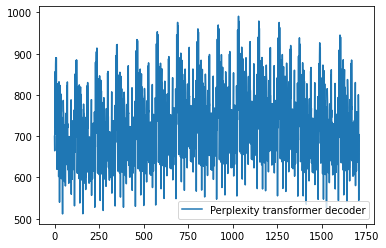

In [ ]:
plt.plot(perplexity_tr_decoder, label = 'Perplexity transformer decoder')
plt.legend()
plt.show()

zzz